Question 1:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plotit(X,Y=None,clf=None,  conts = None, ccolors = ('b','k','r'), colors = ('c','y'), markers = ('s','o'), hold = False, transform = None,extent = None,**kwargs):
    """
    A function for showing data scatter plot and classification boundary
    of a classifier for 2D data
        X: nxd  matrix of data points
        Y: (optional) n vector of class labels
        clf: (optional) classification/discriminant function handle
        conts: (optional) contours (if None, contours are drawn for each class boundary)
        ccolors: (optional) colors for contours   
        colors: (optional) colors for each class (sorted wrt class id)
            can be 'scaled' or 'random' or a list/tuple of color ids
        markers: (optional) markers for each class (sorted wrt class id)
        hold: Whether to hold the plot or not for overlay (default: False).
        transform: (optional) a function handle for transforming data before passing to clf
        kwargs: any keyword arguments to be passed to clf (if any)        
    """
    if clf is not None and X.shape[1]!=2:
        warnings.warn("Data Dimensionality is not 2. Unable to plot.")
        return
    if markers is None:
        markers = ('.',)
    eps=1e-6
    d0,d1 = (0,1)
    if extent is None:
        minx, maxx = np.min(X[:,d0])-eps, np.max(X[:,d0])+eps
        miny, maxy = np.min(X[:,d1])-eps, np.max(X[:,d1])+eps
        extent = [minx,maxx,miny,maxy]
    else:
        [minx,maxx,miny,maxy] = extent
    if Y is not None:
        classes = sorted(set(Y))
        if conts is None:
            conts = list(classes)        
        vmin,vmax = classes[0]-eps,classes[-1]+eps
    else:
        vmin,vmax=-2-eps,2+eps
        if conts is None:            
            conts = sorted([-1+eps,0,1-eps])
        
    if clf is not None:
        npts = 150
        x = np.linspace(minx,maxx,npts)
        y = np.linspace(miny,maxy,npts)
        t = np.array(list(itertools.product(x,y)))
        if transform is not None:
            t = transform(t)
        z = clf(t,**kwargs)
        
        z = np.reshape(z,(npts,npts)).T        
        
        
        plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')
        #plt.imshow(np.flipud(z), extent = extent, cmap=plt.cm.Purples, vmin = -2, vmax = +2); plt.colorbar()
        plt.pcolormesh(x, y, z,cmap=plt.cm.Purples,vmin=vmin,vmax=vmax);plt.colorbar()
        plt.axis(extent)
    
    if Y is not None:        
        for i,y in enumerate(classes):
            if colors is None or colors=='scaled':
                cc = np.array([[i,i,i]])/float(len(classes))
            elif colors =='random':
                cc = np.array([[np.random.rand(),np.random.rand(),np.random.rand()]])
            else:
                cc = colors[i%len(colors)]
            mm = markers[i%len(markers)]
            plt.scatter(X[Y==y,d0],X[Y==y,d1], marker = mm,c = cc, s = 30)     
         
    else:
        plt.scatter(X[:,d0],X[:,d1],marker = markers[0], c = 'k', s = 5)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')   
    if not hold:
        plt.grid()        
        plt.show()
    return extent

In [2]:
CompleteXtest = np.loadtxt('Xtest.csv')
CompleteXtrain = np.loadtxt('Xtrain.csv')
CompleteYtrain = np.loadtxt('Ytrain.csv')

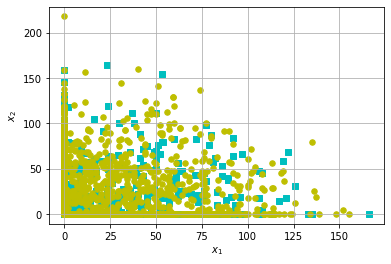

[-1e-06, 166.000001, -1e-06, 218.000001]

In [3]:
plotit(CompleteXtrain,CompleteYtrain)

i. How many training and test examples are there? You can use np.loadtxt for this purpose.
Show at least 10 randomly selected objects of each class using plt.matshow. 

In [4]:
print('There are',CompleteXtrain.shape[0],'training samples.')
print('There are',CompleteXtest.shape[0],'test samples.')

There are 3000 training samples.
There are 3000 test samples.


Each row is an image and there are 3000 rows for the test and training examples. Therefore there are 3000 test and 3000 training examples.

Images in class: -1.0


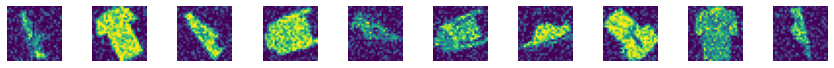

Images in class: 1.0


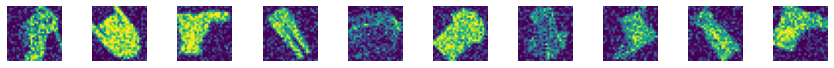

In [5]:
for Yclass in np.unique(CompleteYtrain):
    print('Images in class: '+str(Yclass))
    class_indexes = np.where(CompleteYtrain == Yclass)[0]
    randomindexes = [np.random.randint(len(class_indexes)) for x in range(10)]
    fig = plt.figure(figsize=(15,1))
    for i in range(10):
        index = class_indexes[randomindexes[i]]
        plt.subplot(1,10,i+1)
        plt.axis('off')
        plt.imshow(CompleteXtrain[index].reshape((28,-1)))
    plt.show()

ii. How many positive and negative examples are there in the training dataset?

In [6]:
print('Number of positive examples: '+str(len(np.unique(np.where(CompleteYtrain == 1)[0]))))
print('Number of negative examples: '+str(len(np.unique(np.where(CompleteYtrain == -1)[0]))))

Number of positive examples: 2118
Number of negative examples: 882


iii. Which performance metric (accuracy, AUC-ROC and AUC-PR) should be used? Give your
reasoning.

The data is imbalanced, so accuracy is not a useful metric. AUC-ROC will be somewhat useful for a general indication of performance, but AUC-PR is the best for imbalanced datasets such as this one. That is why I will focus on the AUC-PR score in this assignment.

iv. What is the expected accuracy of a random classifier (one that generates random labels for a
given example) for this problem over the training and test datasets? Demonstrate why this
would be the case.


Assuming the classifier labels randomly (i.e. 50% chance of labelling 1 and 50% chance of labelling -1), the expected accuracy is 1/number_of_classes. This is because they are statistically independent of one another. Therefore, in this problem the expected accuracy of a random classifier is 50%, but there will be slight deviations in practice.

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score

def random_classifier(CompleteXtrain):
    return 2*np.random.randint(0,2,size=(len(CompleteXtrain)))-1

In [8]:
YRandomPred = random_classifier(CompleteXtrain)

print('Accuracy: ',np.mean(YRandomPred == CompleteYtrain))

Accuracy:  0.49833333333333335


In [9]:
from sklearn.dummy import DummyClassifier
dummyclf = DummyClassifier(strategy = 'uniform') #uniform makes the prediction evenly split between the classes.
dummyclf.fit(CompleteXtrain,CompleteYtrain)
YRandomPred = dummyclf.predict(CompleteXtrain)

In [10]:
print('Accuracy:',np.mean(YRandomPred == CompleteYtrain))

Accuracy: 0.503


v. What is the AUC-ROC and AUC-PR of a random classifier for this problem over the training
and test datasets? Demonstrate why this would be the case.

In [8]:
def ROC(y,z,pstr = ''):
    fpr,tpr,tt = roc_curve(y, z)
    roc_auc = auc(fpr, tpr)
    return roc_auc

def PRC(y,z,pstr = ''):
    pr_auc = average_precision_score(y, z)
    return pr_auc

def plotROC(y,z,pstr = ''):
    fpr,tpr,tt = roc_curve(y, z)
    roc_auc = auc(fpr, tpr)
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(tt,fpr,'o-',tt,tpr,'x-');plt.xlabel('threshold');plt.ylabel('Percentage');plt.legend(['FPR','TPR']);plt.grid();plt.title(pstr)
    plt.subplot(1,2,2)
    plt.plot(fpr,tpr,'o-');plt.xlabel('FPR');plt.ylabel('TPR');plt.grid();plt.title('ROC '+pstr+' AUC: '+str(roc_auc))
    return roc_auc

def plotPRC(y,z,pstr = ''):
    P,R,tt = precision_recall_curve(y, z)
    pr_auc = average_precision_score(y, z)
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(tt,R[:-1],'o-',tt,P[:-1],'x-');plt.xlabel('threshold');plt.ylabel('Percentage');plt.legend(['Recall','Precision']);plt.grid();plt.title(pstr)
    plt.subplot(1,2,2)
    plt.plot(R,P,'o-');plt.xlabel('Recall');plt.ylabel('Precision');plt.grid();plt.title('PRC '+pstr+' AUC: '+str(pr_auc))
    return pr_auc

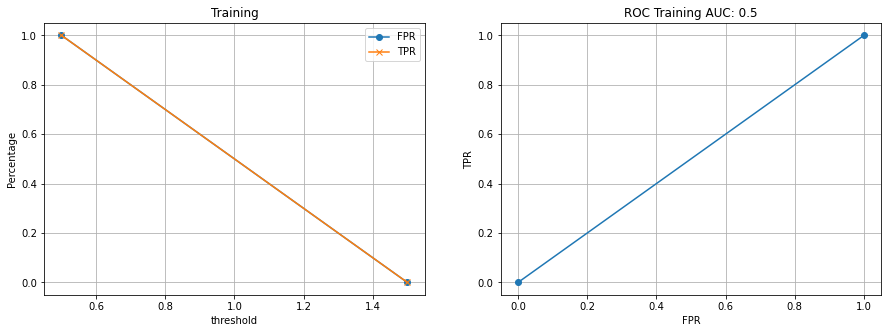

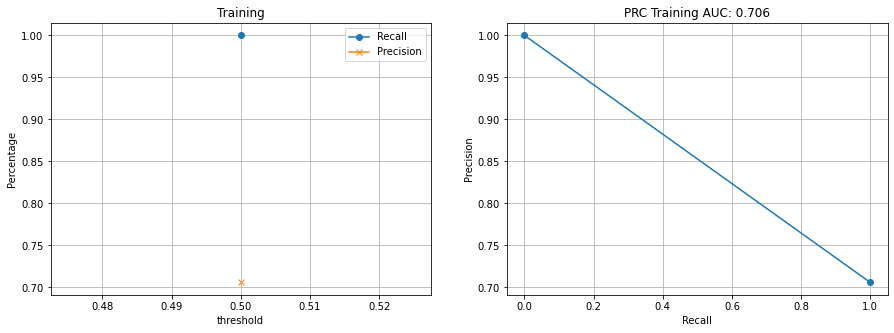

In [12]:
roc_tr = plotROC(CompleteYtrain,dummyclf.predict_proba(CompleteXtrain)[:,0],'Training')
pr_tr = plotPRC(CompleteYtrain,dummyclf.predict_proba(CompleteXtrain)[:,0],'Training')

In [13]:
print('ROC Training AUC: '+str(roc_tr))
print('PRC Training AUC: '+str(pr_tr))

ROC Training AUC: 0.5
PRC Training AUC: 0.706


The ROC curve for the random classifier is a linear line connecting (0,0) to (1,1). This is because the classifier is equally like to label incorrectly as correctly, so the TPR and FPR must always be equal to one another.

The PR curve for the random classifier is a linear line connecting (0,1) to (1,0.7). This is because the best threshold for this classifier will be to label everything as positive due to the imbalance in the dataset, giving a recall of 1 and precision of ~0.7.

Question 2:

In [51]:
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [10]:
Xtrain, Xv, Ytrain, Yv = train_test_split(CompleteXtrain, CompleteYtrain, test_size=0.1, shuffle = True, stratify = None)#, random_state=42)
print(len(Xtrain))

#split the training data into training and validation data, this means I can properly evaluate the performance of a classifier.
#I could have used cross validation (cross_val_score) instead but I decided to use this method.

2700


In [16]:
clf = KNeighborsClassifier()
clf.fit(Xtrain,Ytrain)
a = clf.predict_proba(Xv)[:,1]

In [52]:
skf = StratifiedKFold(n_splits = 5)

In [18]:
def knn(Xtrain,Ytrain,verbose = 0,plot_toggle = 0,n_neighbours=1):
    count = 0
    AUCROC,AUCPRC,ACCURACY = [],[],[]
    for i, (train_index,test_index) in enumerate(skf.split(Xtrain,Ytrain)):
        count+=1
        X_train, X_test = Xtrain[train_index], Xtrain[test_index]
        Y_train, Y_test = Ytrain[train_index], Ytrain[test_index]
        clf = KNeighborsClassifier(n_neighbors=n_neighbours)
        clf = clf.fit(X_train, Y_train)
        Z = clf.predict(X_test)
        prediction_scores = clf.predict_proba(X_test)[:,1]
        if plot_toggle == 0:
            roc_tr = ROC(Y_test,prediction_scores,'Training')
            pr_tr = PRC(Y_test,prediction_scores,'Training')
        else:
            roc_tr = plotROC(Y_test,prediction_scores,'Training')
            pr_tr = plotPRC(Y_test,prediction_scores,'Training')
        AUCROC.append(roc_tr)
        AUCPRC.append(pr_tr)
        ACCURACY.append(np.mean(Z==Y_test))
        if verbose == 1:
            print('Fold: '+str(count))
            print('Accuracy of kNN:',np.mean(Z==Y_test))
            print('ROC Training AUC: '+str(roc_tr))
            print('PRC Training AUC: '+str(pr_tr))
        #     Xplot.append(Ntr)
        #     Yplot.append(np.mean(Z==Ytt))

            print('............................................')
    print('\nAccuracy Mean:',np.mean(ACCURACY))
    print('ROC Mean AUC',np.mean(AUCROC))
    print('ROC Stdev AUC',np.std(AUCROC))
    print('PRC Mean AUC',np.mean(AUCPRC))
    print('PRC Stdev AUC',np.std(AUCPRC))
    return AUCROC,AUCPRC,ACCURACY

i. What is the prediction accuracy, AUC-ROC and AUC-PR for each fold using this classifier?
Show code to demonstrate the results.

ii. What is the mean and standard deviation of each performance metric (accuracy, AUCROC and AUC-PR)across all the folds for this classifier? Show code to demonstrate the
results.

In [33]:
knn(Xtrain,Ytrain,verbose=1,n_neighbours=1)

Fold: 1
Accuracy of kNN: 0.75
ROC Training AUC: 0.7238894666468579
PRC Training AUC: 0.8172894701721607
............................................
Fold: 2
Accuracy of kNN: 0.7481481481481481
ROC Training AUC: 0.7189124944287625
PRC Training AUC: 0.81424870910744
............................................
Fold: 3
Accuracy of kNN: 0.6981481481481482
ROC Training AUC: 0.6614916060020799
PRC Training AUC: 0.782388253728171
............................................
Fold: 4
Accuracy of kNN: 0.7148148148148148
ROC Training AUC: 0.7007874015748032
PRC Training AUC: 0.8049778124581275
............................................
Fold: 5
Accuracy of kNN: 0.7574074074074074
ROC Training AUC: 0.7299342105263158
PRC Training AUC: 0.8193506642423052
............................................

Accuracy Mean: 0.7337037037037037
ROC Mean AUC 0.707003035835764
ROC Stdev AUC 0.02474974697639227
PRC Mean AUC 0.8076509819416409
PRC Stdev AUC 0.013554809455952553


([0.7238894666468579,
  0.7189124944287625,
  0.6614916060020799,
  0.7007874015748032,
  0.7299342105263158],
 [0.8172894701721607,
  0.81424870910744,
  0.782388253728171,
  0.8049778124581275,
  0.8193506642423052],
 [0.75,
  0.7481481481481481,
  0.6981481481481482,
  0.7148148148148148,
  0.7574074074074074])

iii. What is the impact of various forms of pre-processing (https://scikitlearn.org/stable/modules/preprocessing.html ) on the cross-validation performance?
Show code to demonstrate the results.

In [11]:
from sklearn.preprocessing import MinMaxScaler,minmax_scale,MaxAbsScaler,StandardScaler,RobustScaler,Normalizer,QuantileTransformer,PowerTransformer

In [12]:
scaler = StandardScaler().fit(Xtrain)
minmaxscaler = MinMaxScaler().fit(Xtrain)
# minmax_scaler = minmax_scale().fit(Xtrain)
maxabsscaler = MaxAbsScaler().fit(Xtrain)
robustscaler = RobustScaler().fit(Xtrain)
normalizer = Normalizer().fit(Xtrain)
quantiletransformer = QuantileTransformer().fit(Xtrain)
powertransformer = PowerTransformer().fit(Xtrain)

Xscaled = scaler.transform(Xtrain)
Xminmaxscaler = minmaxscaler.transform(Xtrain)
# Xminmax_scaler = minmax_scaler.transform(Xtrain)
Xmaxabsscaler = maxabsscaler.transform(Xtrain)
Xrobustscaler = robustscaler.transform(Xtrain)
Xnormalizer = normalizer.transform(Xtrain)
Xquantiletransformer = quantiletransformer.transform(Xtrain)
Xpowertransformer = powertransformer.transform(Xtrain)

# vscaler = StandardScaler().fit(Xv)
# vminmaxscaler = MinMaxScaler().fit(Xv)
# # vminmax_scaler = minmax_scale().fit(Xv)
# vmaxabsscaler = MaxAbsScaler().fit(Xv)
# vrobustscaler = RobustScaler().fit(Xv)
# vnormalizer = Normalizer().fit(Xv)
# vquantiletransformer = QuantileTransformer().fit(Xv)
# vpowertransformer = PowerTransformer().fit(Xv)

Xvscaled = scaler.transform(Xv)
Xvminmaxscaler = minmaxscaler.transform(Xv)
# Xvminmax_scaler = minmax_scaler.transform(Xv)
Xvmaxabsscaler = maxabsscaler.transform(Xv)
Xvrobustscaler = robustscaler.transform(Xv)
Xvnormalizer = normalizer.transform(Xv)
Xvquantiletransformer = quantiletransformer.transform(Xv)
Xvpowertransformer = powertransformer.transform(Xv)

In [13]:
preprocessing_list = [Xtrain,Xscaled,Xminmaxscaler,Xmaxabsscaler,Xrobustscaler,Xnormalizer,Xquantiletransformer,Xpowertransformer]
preprocessing_validation_list = [Xv,Xvscaled,Xvminmaxscaler,Xvmaxabsscaler,Xvrobustscaler,Xvnormalizer,Xvquantiletransformer,Xvpowertransformer]
preprocessing_names = ['None','StandardScaler','MinMaxScaler','MaxAbsScaler','RobustScaler','Normalizer','QuantileTransformer','PowerTransformer']
preprocessing_dict = dict(zip(preprocessing_names,preprocessing_list))
preprocessing_validation_dict = dict(zip(preprocessing_names,preprocessing_validation_list))

In [34]:
information = []
for i in range(len(preprocessing_list)):
    print('\n',preprocessing_names[i], 'preprocessing: ')
    info = knn(preprocessing_list[i],Ytrain,n_neighbours = 5,verbose=1)
    information.append(info)


 None preprocessing: 
Fold: 1
Accuracy of kNN: 0.7777777777777778
ROC Training AUC: 0.7855527493025636
PRC Training AUC: 0.8642923561129263
............................................
Fold: 2
Accuracy of kNN: 0.7685185185185185
ROC Training AUC: 0.7930058271018009
PRC Training AUC: 0.8748015961529803
............................................
Fold: 3
Accuracy of kNN: 0.7388888888888889
ROC Training AUC: 0.7721240033675035
PRC Training AUC: 0.8678549824007479
............................................
Fold: 4
Accuracy of kNN: 0.725925925925926
ROC Training AUC: 0.7398933623863055
PRC Training AUC: 0.8424128988878845
............................................
Fold: 5
Accuracy of kNN: 0.7925925925925926
ROC Training AUC: 0.7809621710526315
PRC Training AUC: 0.8601645013048229
............................................

Accuracy Mean: 0.7607407407407407
ROC Mean AUC 0.7743076226421609
ROC Stdev AUC 0.018490366357996797
PRC Mean AUC 0.8619052669718723
PRC Stdev AUC 0.0108664188510

In [35]:
mean_ROC_scores = []
mean_PRC_scores = []
mean_accuracy_scores = []
for i in range(len(preprocessing_names)):
    mean_ROC_scores.append(np.mean(information[i][0]))
    mean_PRC_scores.append(np.mean(information[i][1]))
    mean_accuracy_scores.append(np.mean(information[i][2]))

Best preprocessing method for ROC: PowerTransformer


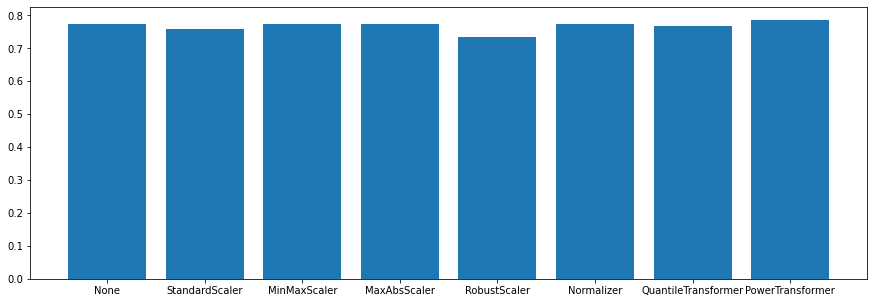

In [36]:
fig = plt.figure(figsize=(15,5))
plt.bar(preprocessing_names,mean_ROC_scores)

print('Best preprocessing method for ROC:',preprocessing_names[np.argmax(mean_ROC_scores)])

Best preprocessing method for PRC: PowerTransformer


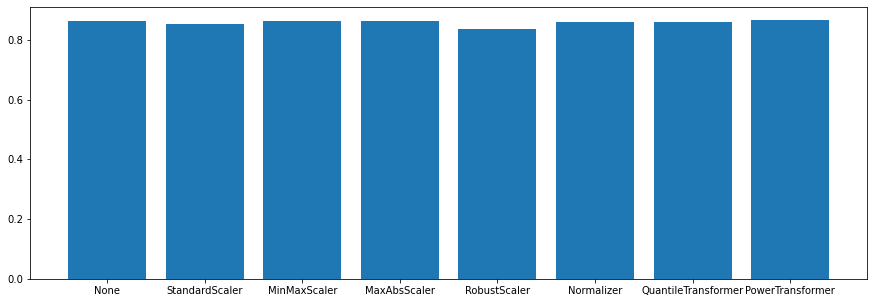

In [37]:
fig = plt.figure(figsize=(15,5))
plt.bar(preprocessing_names,mean_PRC_scores)

print('Best preprocessing method for PRC:',preprocessing_names[np.argmax(mean_PRC_scores)])

Best preprocessing method for accuracy: PowerTransformer


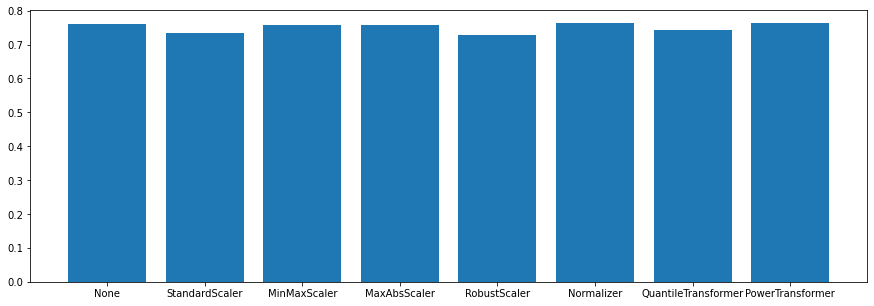

In [38]:
fig = plt.figure(figsize=(15,5))
plt.bar(preprocessing_names,mean_accuracy_scores)

print('Best preprocessing method for accuracy:',preprocessing_names[np.argmax(mean_accuracy_scores)])

iv. Use 5-fold cross-validation over training data to calculate the optimal value of k for the
k-Nearest neighbour classifier. What is the optimal value of k and what are the crossvalidation accuracy, AUC-ROC and AUC-PR? Show code to demonstrate the results.


Optimal value of k should be determined by AUC-PR as the dataset is heavily imbalanced.

In [14]:
from sklearn.model_selection import cross_val_score

In [40]:
k_limit=20

In [42]:
rocscores = []
for n_neighbours in range(1,k_limit):
    clf = KNeighborsClassifier(n_neighbors=n_neighbours)
    score = cross_val_score(clf, Xpowertransformer, Ytrain, cv=5,scoring = 'roc_auc')
    rocscores.append(score)

In [43]:
accuracyscores = []
for n_neighbours in range(1,k_limit):
    clf = KNeighborsClassifier(n_neighbors=n_neighbours)
    score = cross_val_score(clf, Xpowertransformer, Ytrain, cv=5,scoring = 'accuracy')
    accuracyscores.append(score)

In [44]:
prcscores = []
for n_neighbours in range(1,k_limit):
    clf = KNeighborsClassifier(n_neighbors=n_neighbours)
    score = cross_val_score(clf, Xpowertransformer, Ytrain, cv=5,scoring = 'average_precision')
    prcscores.append(score)

Text(0.5, 1.0, 'PRC')

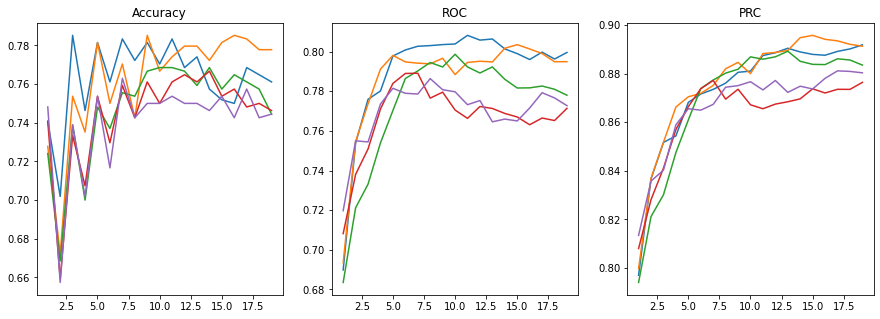

In [45]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot([i for i in range(1,k_limit)],accuracyscores)
plt.title('Accuracy')

plt.subplot(1,3,2)
plt.plot([i for i in range(1,k_limit)],rocscores)
plt.title('ROC')

plt.subplot(1,3,3)
plt.plot([i for i in range(1,k_limit)],prcscores)
plt.title('PRC')

Text(0, 0.5, 'Average AUPRC across Folds')

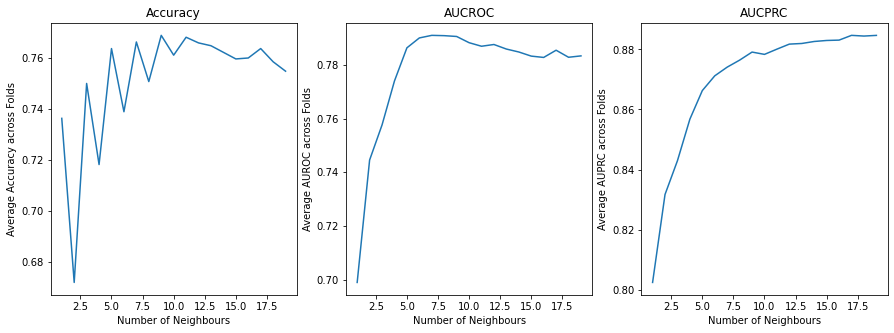

In [46]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot([i for i in range(1,k_limit)],[np.mean(i) for i in zip(accuracyscores)])
plt.title('Accuracy')
plt.xlabel('Number of Neighbours')
plt.ylabel('Average Accuracy across Folds')
plt.subplot(1,3,2)
plt.plot([i for i in range(1,k_limit)],[np.mean(i) for i in zip(rocscores)])
plt.title('AUCROC')
plt.xlabel('Number of Neighbours')
plt.ylabel('Average AUROC across Folds')
plt.subplot(1,3,3)
plt.plot([i for i in range(1,k_limit)],[np.mean(i) for i in zip(prcscores)])
plt.title('AUCPRC')
plt.xlabel('Number of Neighbours')
plt.ylabel('Average AUPRC across Folds')

In [47]:
print('Optimal n_neighbour value:',np.argmax([np.mean(i) for i in zip(prcscores)]))

Optimal n_neighbour value: 16


Question 3:

Use 5-fold stratified cross-validation over training data to choose an optimal classifier
between: k-nearest neighbour, Perceptron, Naïve Bayes Classifier, Logistic regression,
Linear SVM and Kernelized SVM. Be sure to tune the hyperparameters of each classifier
type (k for k-nearest neighbour, C and kernel type and parameters for SVM and so on).
Report the cross validation results (mean and standard deviation of accuracy, AUC-ROC
and AUC-PR across fold) of your best model. You may look into grid search as well as
ways of pre-processing data. Show code to demonstrate the results. Also show the
comparison of these classifiers using a single table.

In [15]:
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.naive_bayes import GaussianNB
classifier_list = [LinearSVC(), Perceptron(), LogisticRegression(), GaussianNB(), SVC(kernel='poly'), SVC(kernel='rbf'), SVC(kernel='sigmoid')]
classifier_names = ['linear svm','perceptron','logistic regression','naive bayes','poly svm','rbf svm','sigmoid svm']
from sklearn.model_selection import GridSearchCV

In [16]:
def preprocess_plotter(trainingPRClist,validationPRClist):
    plt.figure(figsize=(15, 5))
    plt.plot(preprocessing_names,trainingPRClist)
    plt.plot(preprocessing_names,validationPRClist)
    plt.legend(['Training PRC','Validation PRC'])
    plt.show()

def choose_preprocessor(classifier,plot_toggle=1):
    trainingPRClist = []
    validationPRClist = []
    if 'decision_function' in dir(classifier):
        for key in preprocessing_dict.keys():
            classifier.fit(preprocessing_dict[key],Ytrain)
            trainingPRC = PRC(Ytrain,classifier.decision_function(preprocessing_dict[key]))
            trainingPRClist.append(trainingPRC)
            validationPRC = PRC(Yv,classifier.decision_function(preprocessing_validation_dict[key]))
            validationPRClist.append(validationPRC)
        if plot_toggle == 1:
            preprocess_plotter(trainingPRClist,validationPRClist)
        print('Best preprocessor in training:',preprocessing_names[np.argmax(trainingPRClist)])
        print('Best preprocessor in validation:',preprocessing_names[np.argmax(validationPRClist)])
        return trainingPRClist,validationPRClist
    else:
        for key in preprocessing_dict.keys():
            classifier.fit(preprocessing_dict[key],Ytrain)
            trainingPRC = PRC(Ytrain,classifier.predict_proba(preprocessing_dict[key])[:,1])
            trainingPRClist.append(trainingPRC)
            validationPRC = PRC(Yv,classifier.predict_proba(preprocessing_validation_dict[key])[:,1])
            validationPRClist.append(validationPRC)
        if plot_toggle == 1:
            preprocess_plotter(trainingPRClist,validationPRClist)
        print('Best preprocessor in training:',preprocessing_names[np.argmax(trainingPRClist)])
        print('Best preprocessor in validation:',preprocessing_names[np.argmax(validationPRClist)])
        return trainingPRClist,validationPRClist

In [56]:
for i in range(len(classifier_list)):
    print(classifier_names[i])
    print(np.where(np.array(dir(classifier_list[i])) == 'predict_proba'))
    print(np.where(np.array(dir(classifier_list[i])) == 'decision_function'),'\n')

linear svm
(array([], dtype=int64),)
(array([40], dtype=int64),) 

perceptron
(array([], dtype=int64),)
(array([57], dtype=int64),) 

logistic regression
(array([54], dtype=int64),)
(array([40], dtype=int64),) 

naive bayes
(array([48], dtype=int64),)
(array([], dtype=int64),) 

poly svm
(array([78], dtype=int64),)
(array([65], dtype=int64),) 

rbf svm
(array([78], dtype=int64),)
(array([65], dtype=int64),) 

sigmoid svm
(array([78], dtype=int64),)
(array([65], dtype=int64),) 



Perceptron

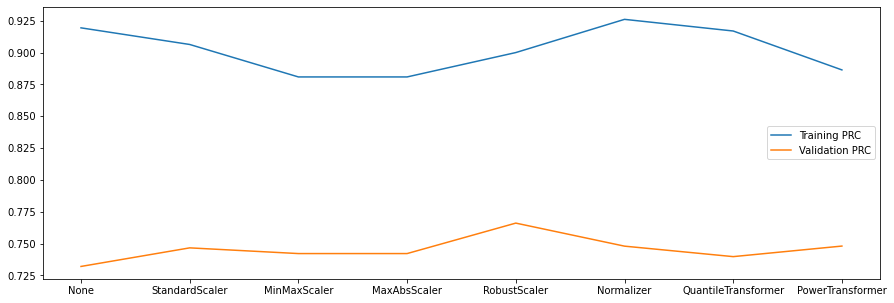

Best preprocessor in training: Normalizer
Best preprocessor in validation: RobustScaler


([0.9194628247981025,
  0.9063993626410627,
  0.8808918818022822,
  0.8808918818022822,
  0.9000456710205442,
  0.92613768797779,
  0.9169865794108112,
  0.8864114428903486],
 [0.7319806374085105,
  0.7465816136057217,
  0.7421018236962675,
  0.7421018236962675,
  0.7660383813500982,
  0.7479308104123302,
  0.73969485783053,
  0.7479922668218227])

In [57]:
choose_preprocessor(Perceptron(),plot_toggle=1)

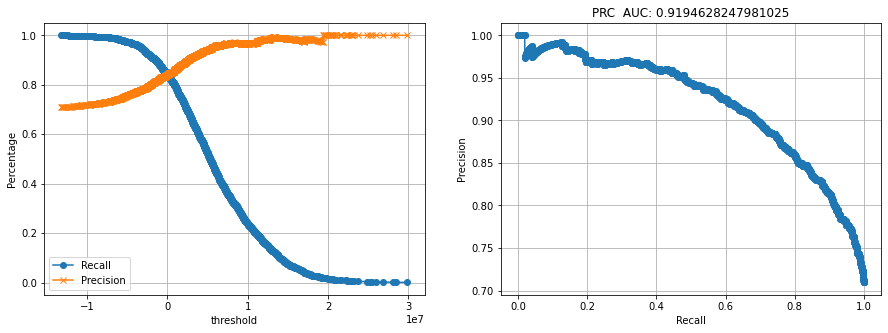

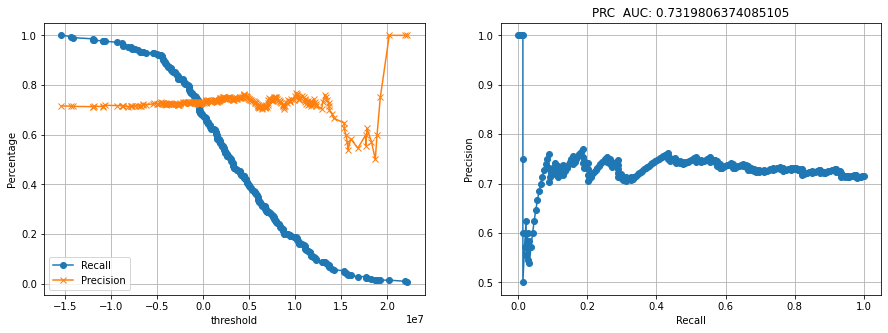

In [58]:
perc = Perceptron()
perc.fit(Xtrain,Ytrain)
cross_val_score(perc,Xtrain,Ytrain,scoring='average_precision')
trainPRC = plotPRC(Ytrain,perc.decision_function(Xtrain))
validPRC = plotPRC(Yv,perc.decision_function(Xv))

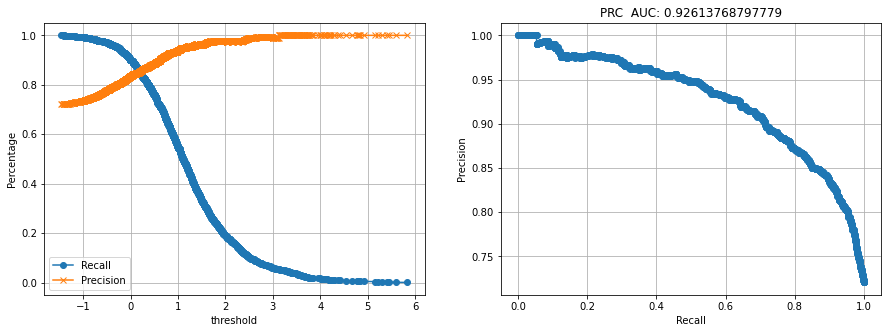

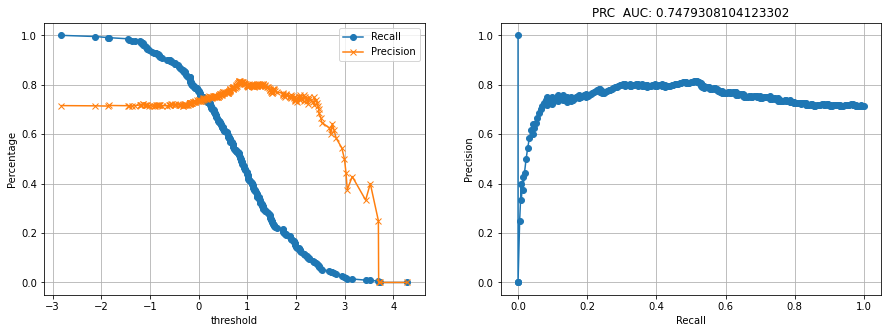

In [191]:
perc = Perceptron()
perc.fit(Xnormalizer,Ytrain)
cross_val_score(perc,Xscaled,Ytrain,scoring='average_precision')
trainPRC = plotPRC(Ytrain,perc.decision_function(Xnormalizer))
validPRC = plotPRC(Yv,perc.decision_function(Xvnormalizer))

So normalized preprocessing with a perceptron gives the best AUCPRC score of 0.7479. This classifier does not work well with this dataset.

In [38]:
PResults = ['N/A','Normalized',trainPRC,validPRC]

K-Nearest Neighbours

In [60]:
import pandas as pd
from sklearn import datasets
from sklearn.metrics import classification_report

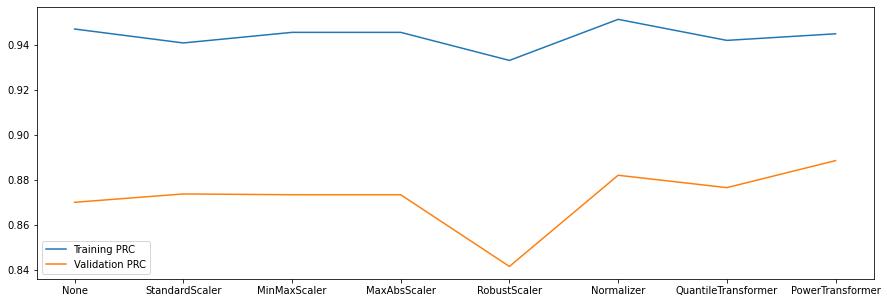

Best preprocessor in training: Normalizer
Best preprocessor in validation: PowerTransformer


([0.9471716197179487,
  0.9409826216535147,
  0.9456861478282983,
  0.9456861478282983,
  0.933222937329224,
  0.9514637726826735,
  0.942121514537664,
  0.9450450788161624],
 [0.8701936839565976,
  0.8739028963116332,
  0.8735520555554372,
  0.8735520555554372,
  0.8416962297471606,
  0.8822057204854897,
  0.8767067302407543,
  0.8887051195002713])

In [61]:
choose_preprocessor(KNeighborsClassifier(),plot_toggle=1)

0.8701936839565976

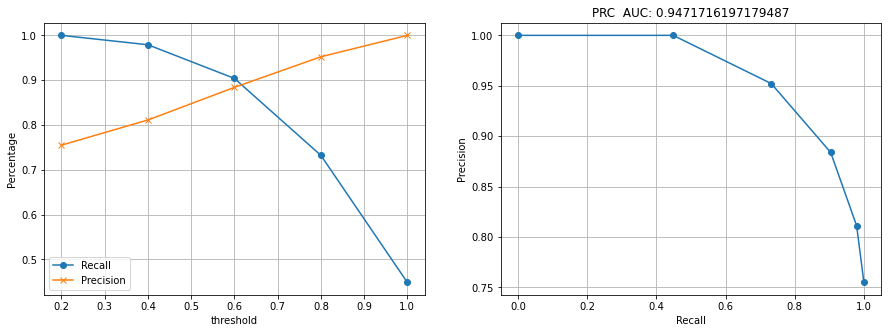

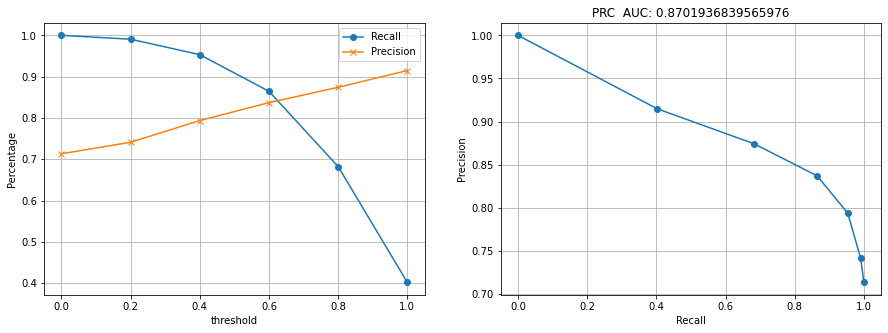

In [63]:
clf = KNeighborsClassifier()
clf.fit(Xtrain,Ytrain)

plotPRC(Ytrain,clf.predict_proba(Xtrain)[:,1])
plotPRC(Yv,clf.predict_proba(Xv)[:,1])

0.8822057204854897

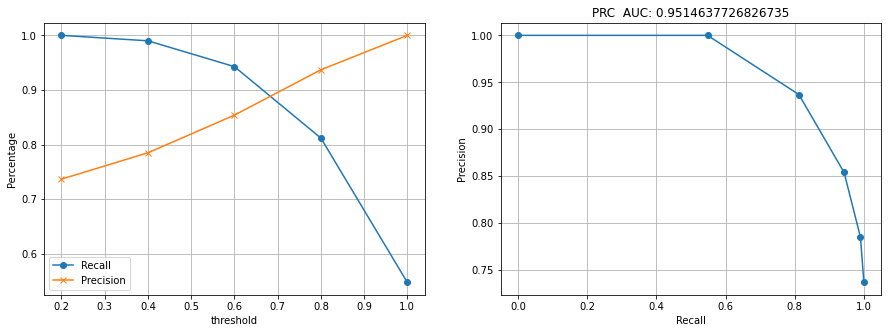

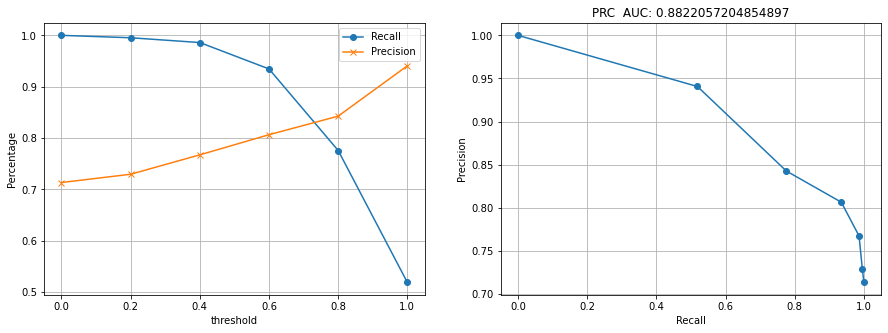

In [64]:
clf = KNeighborsClassifier()
clf.fit(Xnormalizer,Ytrain)

plotPRC(Ytrain,clf.predict_proba(Xnormalizer)[:,1])
plotPRC(Yv,clf.predict_proba(Xvnormalizer)[:,1])

0.827652052293721

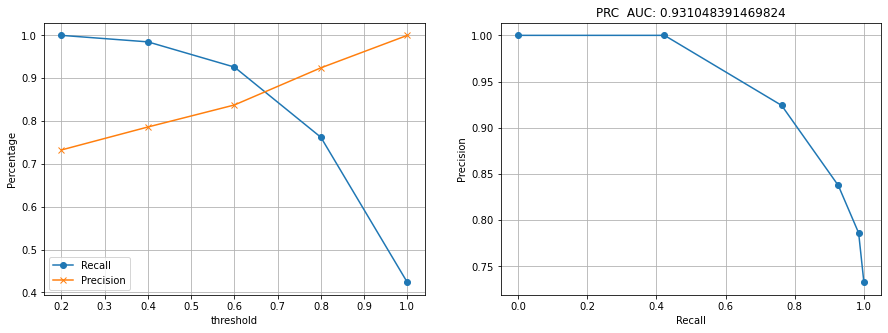

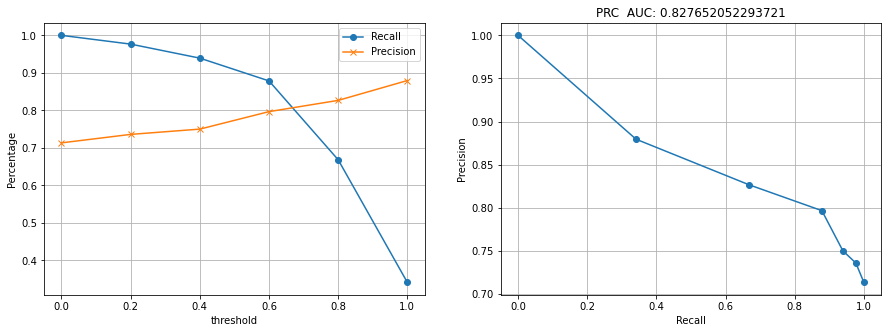

In [65]:
clf = KNeighborsClassifier()
clf.fit(Xrobustscaler,Ytrain)

plotPRC(Ytrain,clf.predict_proba(Xpowertransformer)[:,1])
plotPRC(Yv,clf.predict_proba(Xvpowertransformer)[:,1])

In [67]:
parameters = {'n_neighbors':[i for i in range(1,25)]}
KNeighborsClassifierclf = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, scoring='average_precision',verbose=1)
KNeighborsClassifierclf.fit(Xtrain, Ytrain)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  3.1min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24]},
             scoring='average_precision', verbose=1)

In [68]:
KNeighborsClassifierdata = pd.DataFrame(KNeighborsClassifierclf.cv_results_)

In [69]:
KNeighborsClassifierdata[['mean_fit_time','params','mean_test_score','std_test_score']]

mean_fit_time               params  mean_test_score  std_test_score
0        0.293814   {'n_neighbors': 1}         0.807651        0.013555
1        0.278455   {'n_neighbors': 2}         0.835312        0.008399
2        0.280649   {'n_neighbors': 3}         0.847451        0.012303
3        0.282844   {'n_neighbors': 4}         0.857872        0.010866
4        0.281447   {'n_neighbors': 5}         0.861905        0.010866
5        0.283841   {'n_neighbors': 6}         0.864345        0.010288
6        0.280849   {'n_neighbors': 7}         0.867277        0.010905
7        0.278655   {'n_neighbors': 8}         0.868883        0.009944
8        0.277857   {'n_neighbors': 9}         0.871424        0.009211
9        0.282046  {'n_neighbors': 10}         0.868542        0.010115
10       0.276859  {'n_neighbors': 11}         0.868580        0.009550
11       0.278056  {'n_neighbors': 12}         0.867748        0.007390
12       0.276860  {'n_neighbors': 13}         0.870101        0.007223
13       0.278655  {'n_neighbors': 14}         0.868378        0.007287
14       0.279852  {'n_neighbors': 15}         0.867960        0.008709
15       0.277059  {'n_neighbors': 16}         0.867364        0.009210
16       0.282445  {'n_neighbors': 17}         0.866627        0.009205
17       0.277059  {'n_neighbors': 18}         0.865740        0.010266
18       0.277857  {'n_neighbors': 19}         0.864865        0.012185
19       0.284838  {'n_neighbors': 20}         0.864114        0.014334
20       0.278854  {'n_neighbors': 21}         0.864715        0.014590
21       0.277458  {'n_neighbors': 22}         0.864046        0.013005
22       0.277657  {'n_neighbors': 23}         0.862697        0.013444
23       0.277259  {'n_neighbors': 24}         0.861989        0.013817

In [70]:
KNeighborsClassifierclf.best_params_

{'n_neighbors': 9}

0.876035214461014

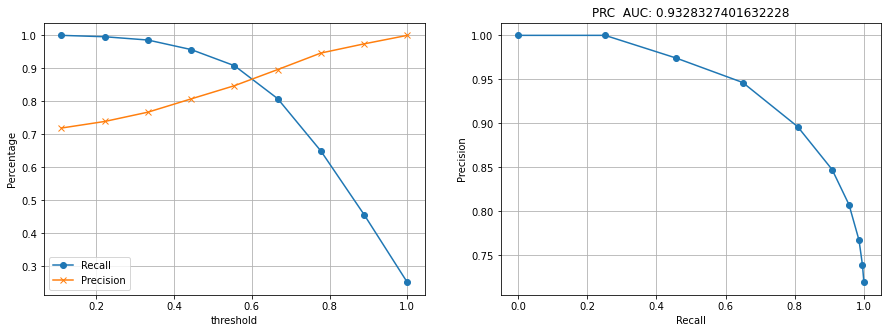

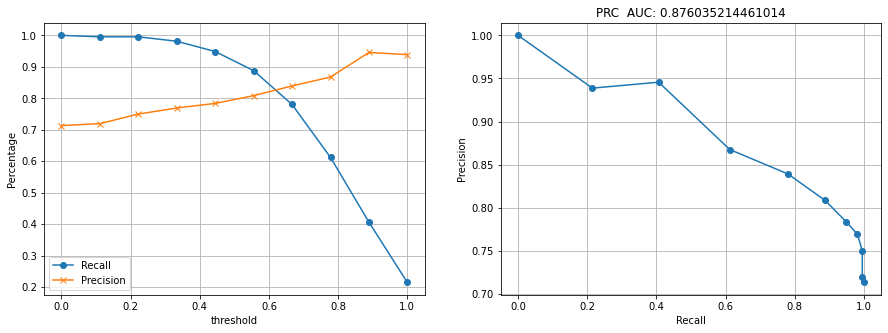

In [71]:
plotPRC(Ytrain,KNeighborsClassifierclf.predict_proba(Xtrain)[:,1])
plotPRC(Yv,KNeighborsClassifierclf.predict_proba(Xv)[:,1])

Using Powertransformer preprocessing

In [72]:
parameters = {'n_neighbors':[i for i in range(1,25)]}
KNeighborsClassifierclf = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, scoring='average_precision',verbose=1)
KNeighborsClassifierclf.fit(Xpowertransformer, Ytrain)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  3.1min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24]},
             scoring='average_precision', verbose=1)

In [73]:
KNeighborsClassifierdata = pd.DataFrame(KNeighborsClassifierclf.cv_results_)

In [74]:
KNeighborsClassifierdata[['mean_fit_time','params','mean_test_score','std_test_score']]

mean_fit_time               params  mean_test_score  std_test_score
0        0.238961   {'n_neighbors': 1}         0.802446        0.007199
1        0.237764   {'n_neighbors': 2}         0.831715        0.006202
2        0.238163   {'n_neighbors': 3}         0.842960        0.008104
3        0.238163   {'n_neighbors': 4}         0.856784        0.006102
4        0.238163   {'n_neighbors': 5}         0.866288        0.003170
5        0.237964   {'n_neighbors': 6}         0.871194        0.003264
6        0.246939   {'n_neighbors': 7}         0.874089        0.003667
7        0.244147   {'n_neighbors': 8}         0.876418        0.004414
8        0.241354   {'n_neighbors': 9}         0.879099        0.004170
9        0.240557  {'n_neighbors': 10}         0.878332        0.006491
10       0.253322  {'n_neighbors': 11}         0.880074        0.009081
11       0.247339  {'n_neighbors': 12}         0.881748        0.008334
12       0.245144  {'n_neighbors': 13}         0.881959        0.009584
13       0.244347  {'n_neighbors': 14}         0.882625        0.009209
14       0.244147  {'n_neighbors': 15}         0.882959        0.008482
15       0.238961  {'n_neighbors': 16}         0.883080        0.007611
16       0.239759  {'n_neighbors': 17}         0.884662        0.006869
17       0.246142  {'n_neighbors': 18}         0.884428        0.006696
18       0.238562  {'n_neighbors': 19}         0.884649        0.006062
19       0.237365  {'n_neighbors': 20}         0.885255        0.006014
20       0.237565  {'n_neighbors': 21}         0.885864        0.004636
21       0.237565  {'n_neighbors': 22}         0.885568        0.004102
22       0.237964  {'n_neighbors': 23}         0.884205        0.005513
23       0.238163  {'n_neighbors': 24}         0.882239        0.005605

In [75]:
KNeighborsClassifierclf.best_params_

{'n_neighbors': 21}

0.8972281630541087

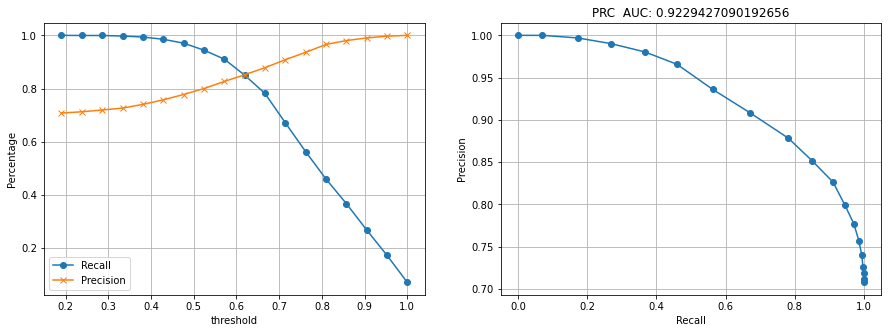

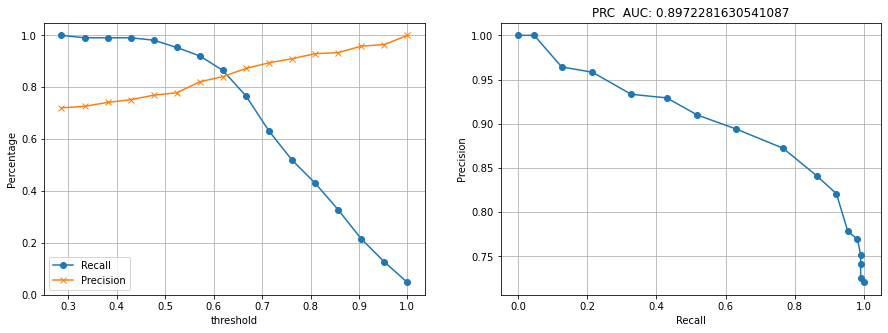

In [76]:
plotPRC(Ytrain,KNeighborsClassifierclf.predict_proba(Xpowertransformer)[:,1])
plotPRC(Yv,KNeighborsClassifierclf.predict_proba(Xvpowertransformer)[:,1])

Using normalized preprocessing

In [77]:
parameters = {'n_neighbors':[i for i in range(1,20)]}
KNeighborsClassifierclf = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, scoring='average_precision',verbose=1)
KNeighborsClassifierclf.fit(Xnormalizer, Ytrain)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:  2.5min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19]},
             scoring='average_precision', verbose=1)

In [78]:
KNeighborsClassifierdata = pd.DataFrame(KNeighborsClassifierclf.cv_results_)

In [79]:
KNeighborsClassifierdata[['mean_fit_time','params','mean_test_score','std_test_score']]

mean_fit_time               params  mean_test_score  std_test_score
0        0.283442   {'n_neighbors': 1}         0.807282        0.011330
1        0.290224   {'n_neighbors': 2}         0.832497        0.003728
2        0.286434   {'n_neighbors': 3}         0.849238        0.003128
3        0.274665   {'n_neighbors': 4}         0.854786        0.003548
4        0.275862   {'n_neighbors': 5}         0.858997        0.005246
5        0.275065   {'n_neighbors': 6}         0.864673        0.007498
6        0.273668   {'n_neighbors': 7}         0.865800        0.002779
7        0.280649   {'n_neighbors': 8}         0.868559        0.005302
8        0.279652   {'n_neighbors': 9}         0.869657        0.006492
9        0.272471  {'n_neighbors': 10}         0.871877        0.006239
10       0.281048  {'n_neighbors': 11}         0.870669        0.008241
11       0.272471  {'n_neighbors': 12}         0.871960        0.009078
12       0.273269  {'n_neighbors': 13}         0.870890        0.011908
13       0.276061  {'n_neighbors': 14}         0.868987        0.012213
14       0.273269  {'n_neighbors': 15}         0.868736        0.014383
15       0.273069  {'n_neighbors': 16}         0.868255        0.013666
16       0.305782  {'n_neighbors': 17}         0.869870        0.013574
17       0.292019  {'n_neighbors': 18}         0.869452        0.014017
18       0.294213  {'n_neighbors': 19}         0.868351        0.012885

In [80]:
KNeighborsClassifierclf.best_params_

{'n_neighbors': 12}

0.8813726208010679

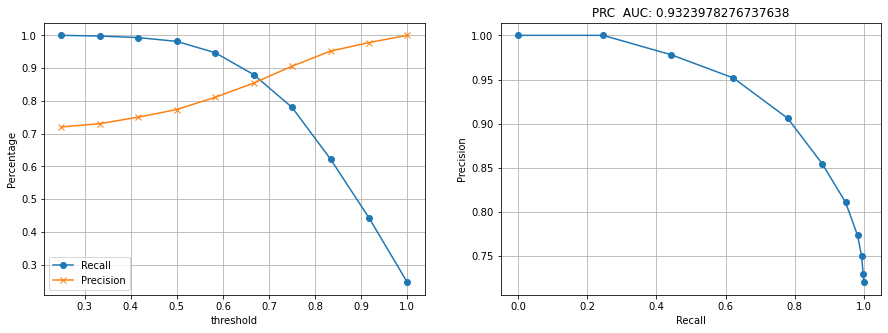

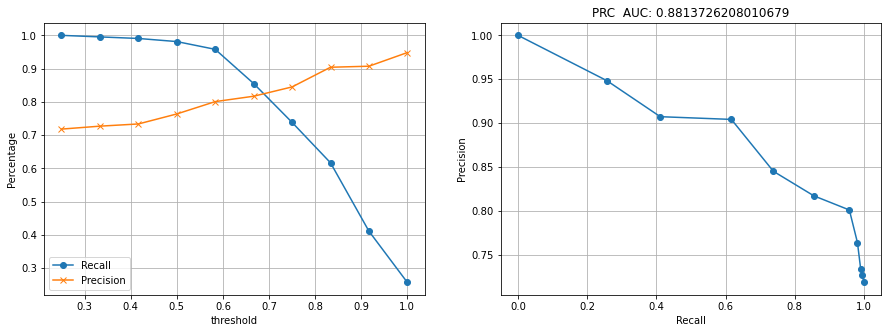

In [81]:
trainPRC = plotPRC(Ytrain,KNeighborsClassifierclf.predict_proba(Xnormalizer)[:,1])
validPRC = plotPRC(Yv,KNeighborsClassifierclf.predict_proba(Xvnormalizer)[:,1])

On the unprocessed training data, the best results with k-nearest neighbour is k=9 with a training AUCPRC of 0.9328 and validation AUCPRC of 0.8760.

On the powertransformer training data, the best results with k-nearest neighbour is k=21 with a training AUCPRC of 0.9229 and validation AUCPRC of 0.8972.

On the normalized training data, the best results with k-nearest neighbour is k=12 with a training AUCPRC of 0.9324 and validation AUCPRC of 0.8814.

Therefore I believe k=12 on normalized data is the optimal classifier as I value the AUCPRC on the validation set more than the training.

In [40]:
KNNResults = ['n_neighbors = 12','Normalized',trainPRC,validPRC]

Naive Bayes

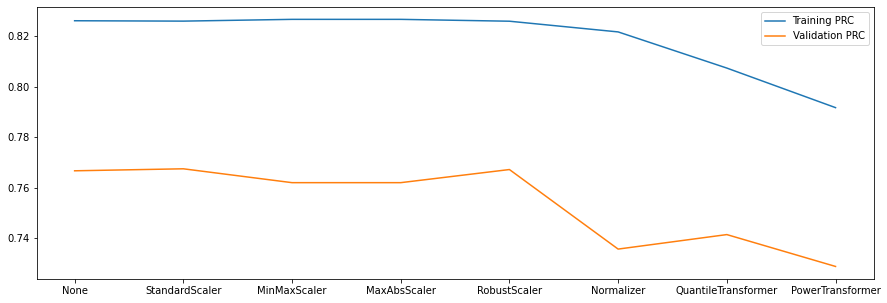

Best preprocessor in training: MinMaxScaler
Best preprocessor in validation: StandardScaler


([0.8261259881973269,
  0.8259745236760903,
  0.826676938437394,
  0.826676938437394,
  0.8259399564892362,
  0.8216982954659767,
  0.807363447483161,
  0.7916783590470291],
 [0.7666363692821551,
  0.7674303292836901,
  0.7619342801846741,
  0.7619342801846741,
  0.7671363509945954,
  0.7356006270124527,
  0.741349254428439,
  0.7287180101206957])

In [83]:
choose_preprocessor(GaussianNB(),plot_toggle=1)

0.7666363692821551

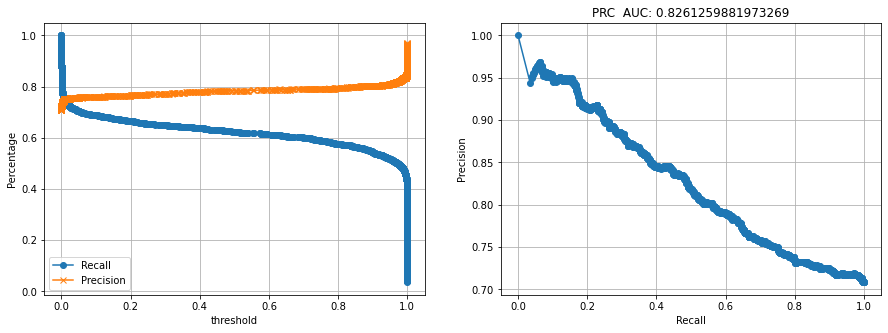

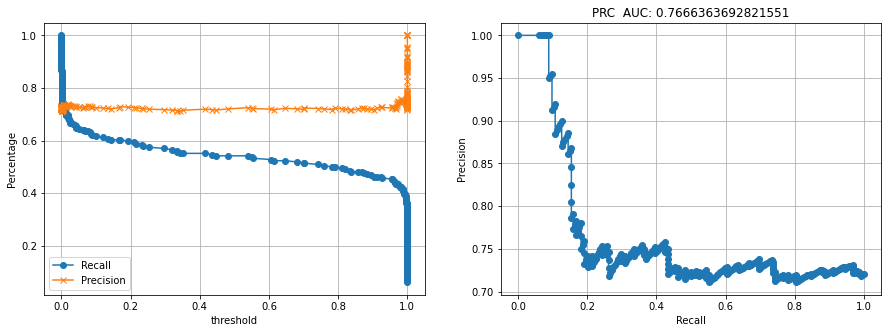

In [84]:
clf = GaussianNB()
clf.fit(Xtrain, Ytrain)
plotPRC(Ytrain,clf.predict_proba(Xtrain)[:,1])
plotPRC(Yv,clf.predict_proba(Xv)[:,1])

In [85]:
parameters = {'var_smoothing':np.logspace(0,-9, num=100)}
NaiveBayesclf = GridSearchCV(GaussianNB(), parameters, cv=5, scoring='average_precision',verbose=1)
NaiveBayesclf.fit(Xtrain, Ytrain)
NaiveBayesdata = pd.DataFrame(NaiveBayesclf.cv_results_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   16.6s finished


In [86]:
NaiveBayesdata[['mean_fit_time','params','mean_test_score','std_test_score']]

mean_fit_time                                     params  mean_test_score  \
0        0.027127                     {'var_smoothing': 1.0}         0.762278   
1        0.031117      {'var_smoothing': 0.8111308307896871}         0.763487   
2        0.026529       {'var_smoothing': 0.657933224657568}         0.764734   
3        0.025731       {'var_smoothing': 0.533669923120631}         0.765980   
4        0.025931     {'var_smoothing': 0.43287612810830584}         0.767905   
..            ...                                        ...              ...   
95       0.025731   {'var_smoothing': 2.310129700083158e-09}         0.769959   
96       0.025332   {'var_smoothing': 1.873817422860387e-09}         0.769959   
97       0.025732   {'var_smoothing': 1.519911082952933e-09}         0.769959   
98       0.025332  {'var_smoothing': 1.2328467394420635e-09}         0.769959   
99       0.024933                   {'var_smoothing': 1e-09}         0.769959   

    std_test_score  
0         0.025892  
1         0.026022  
2         0.025672  
3         0.025920  
4         0.025487  
..             ...  
95        0.021881  
96        0.021881  
97        0.021881  
98        0.021881  
99        0.021881  

[100 rows x 4 columns]

In [87]:
NaiveBayesclf.best_params_

{'var_smoothing': 0.1}

0.7613131563167583

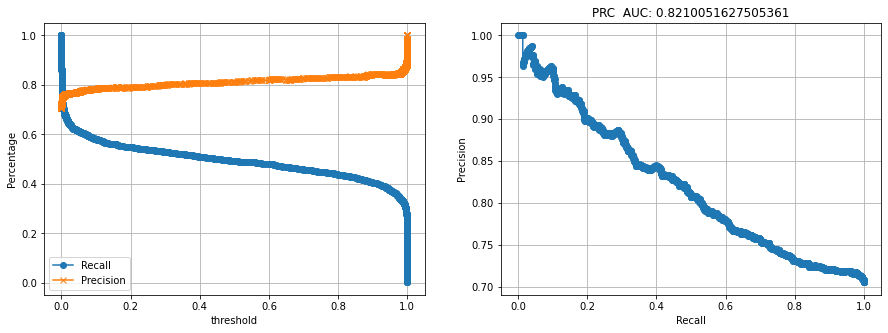

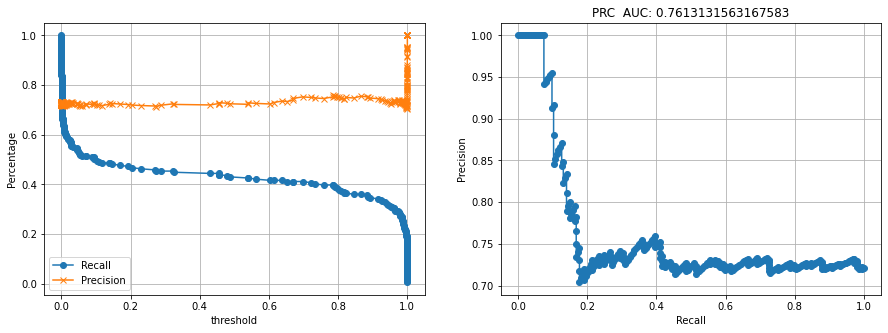

In [88]:
plotPRC(Ytrain,NaiveBayesclf.predict_proba(Xtrain)[:,1])
plotPRC(Yv,NaiveBayesclf.predict_proba(Xv)[:,1])

In [90]:
parameters = {'var_smoothing':np.logspace(0,-9, num=100)}
NaiveBayesclf = GridSearchCV(GaussianNB(), parameters, cv=5, scoring='average_precision',verbose=1)
NaiveBayesclf.fit(Xscaled, Ytrain)
NaiveBayesdata = pd.DataFrame(NaiveBayesclf.cv_results_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   17.6s finished


In [91]:
NaiveBayesclf.best_params_

{'var_smoothing': 0.01873817422860384}

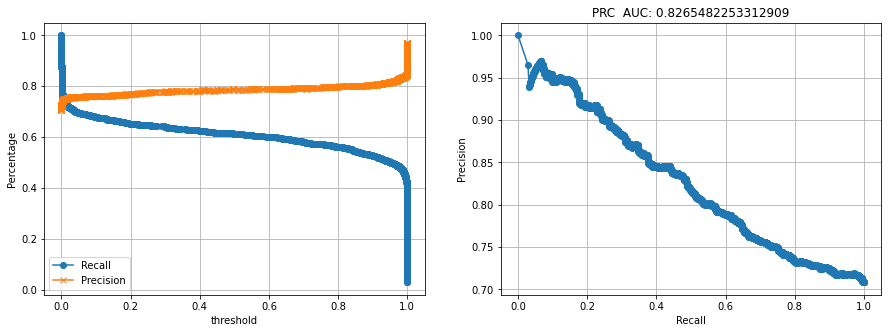

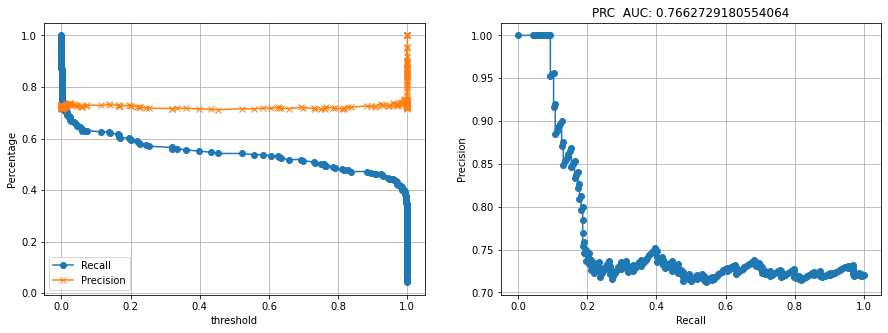

In [94]:
trainPRC = plotPRC(Ytrain,NaiveBayesclf.predict_proba(Xscaled)[:,1])
validPRC = plotPRC(Yv,NaiveBayesclf.predict_proba(Xvscaled)[:,1])

In [41]:
NBResults = ['var_smoothing = 0.18738','StandardScaler',trainPRC,validPRC]

Logistic Regression

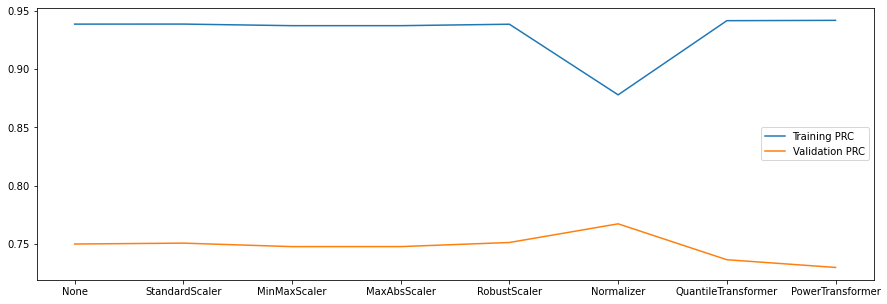

Best preprocessor in training: PowerTransformer
Best preprocessor in validation: Normalizer


([0.9386189771413301,
  0.9386496964843056,
  0.9372908719700614,
  0.9372850109858448,
  0.9385316997208826,
  0.8779543050903387,
  0.9415700854133939,
  0.9418472186872138],
 [0.7499845836558983,
  0.7507514944364818,
  0.747745665520088,
  0.7477755526675456,
  0.7512966931708309,
  0.767303497570476,
  0.7365172325927996,
  0.7298916898312287])

In [97]:
choose_preprocessor(LogisticRegression(max_iter=10000))

0.7499845836558983

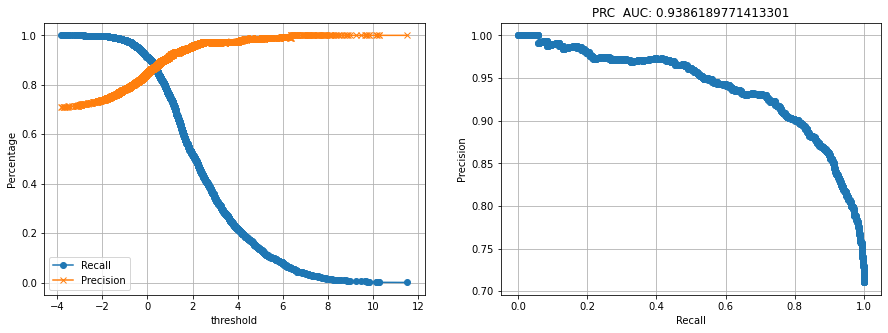

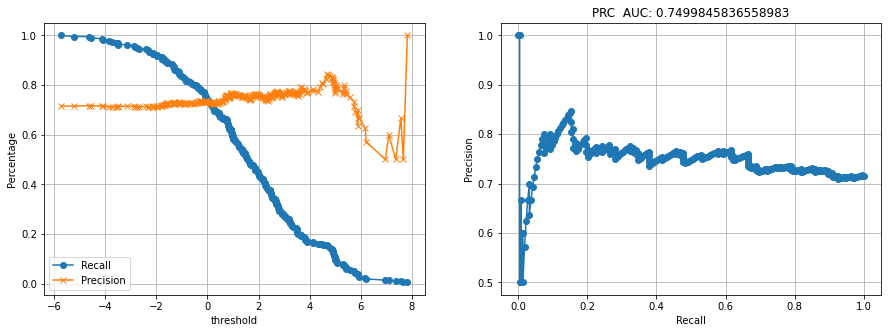

In [98]:
clf = LogisticRegression(max_iter=10000)
clf.fit(Xtrain,Ytrain)
plotPRC(Ytrain,clf.decision_function(Xtrain))
plotPRC(Yv,clf.decision_function(Xv))

0.767303497570476

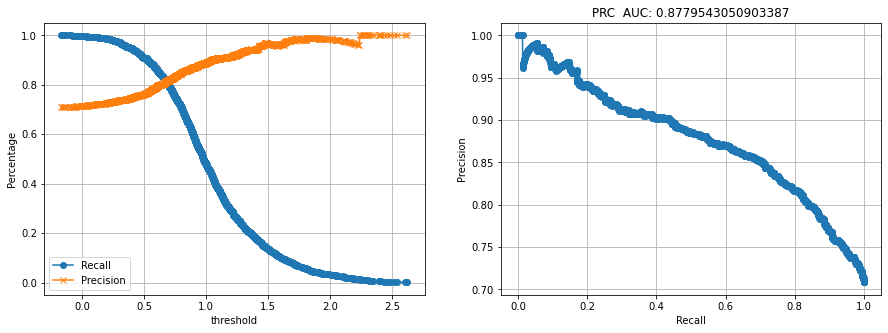

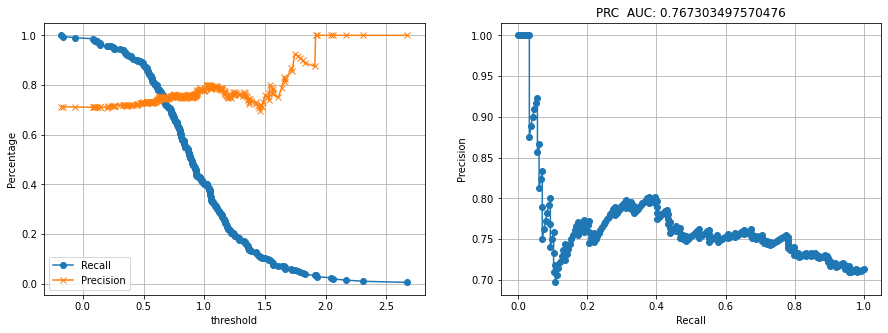

In [99]:
clf = LogisticRegression(max_iter=10000)
clf.fit(Xnormalizer,Ytrain)
plotPRC(Ytrain,clf.decision_function(Xnormalizer))
plotPRC(Yv,clf.decision_function(Xvnormalizer))

In [110]:
parameters = {'penalty' : ['l1', 'l2'], 'C' : np.logspace(-4, 4, 20)}
LogisticRegressionclf = GridSearchCV(LogisticRegression(max_iter=100000), parameters, cv=5, scoring='average_precision',verbose=1)
LogisticRegressionclf.fit(Xnormalizer, Ytrain)
LogisticRegressiondata = pd.DataFrame(LogisticRegressionclf.cv_results_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_v

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_v

0.7691963434931237

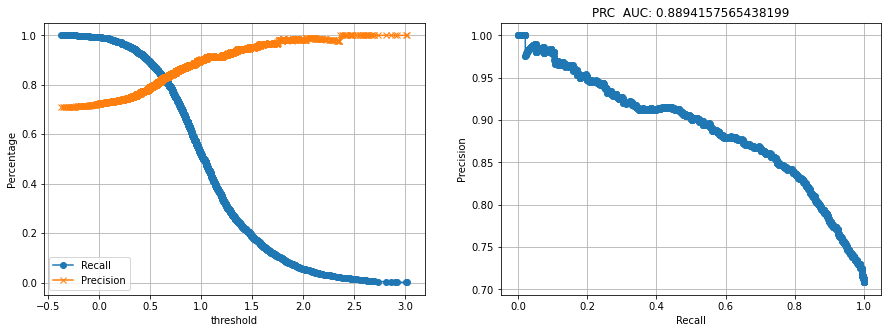

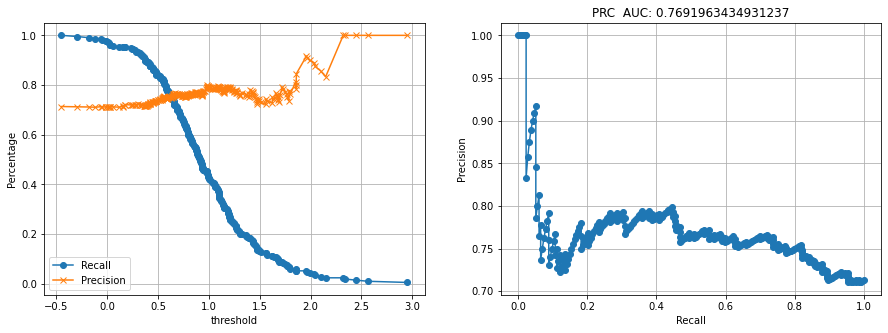

In [111]:
plotPRC(Ytrain,LogisticRegressionclf.decision_function(Xnormalizer))
plotPRC(Yv,LogisticRegressionclf.decision_function(Xvnormalizer))

In [112]:
parameters = {'penalty' : ['l2'], 'C' : np.arange(0.1,5,0.1)}
LogisticRegressionclf = GridSearchCV(LogisticRegression(max_iter=100000), parameters, cv=5, scoring='average_precision',verbose=1)
LogisticRegressionclf.fit(Xnormalizer, Ytrain)
LogisticRegressiondata = pd.DataFrame(LogisticRegressionclf.cv_results_)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:   20.3s finished


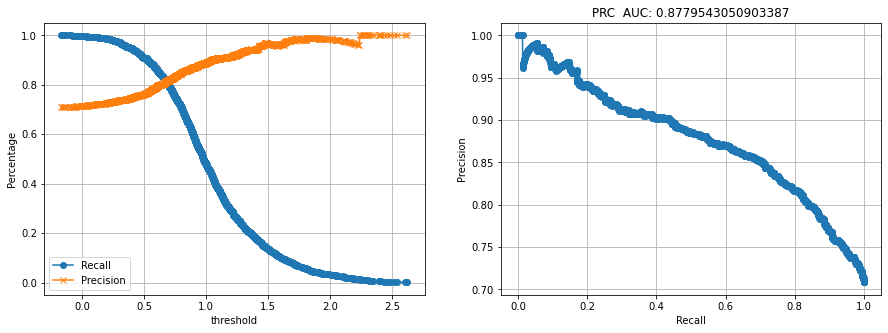

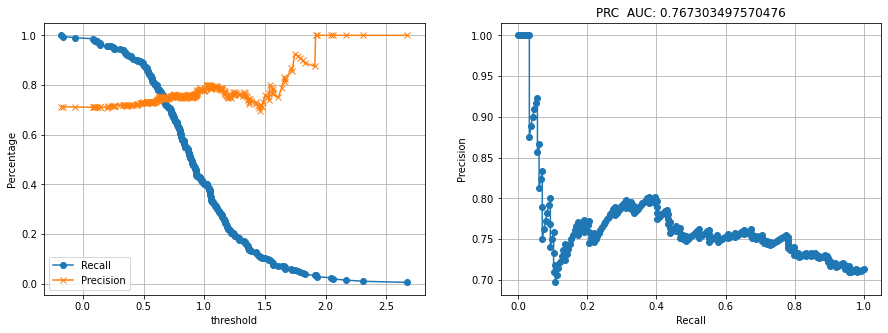

In [113]:
trainPRC = plotPRC(Ytrain,LogisticRegressionclf.decision_function(Xnormalizer))
validPRC = plotPRC(Yv,LogisticRegressionclf.decision_function(Xvnormalizer))

In [114]:
LogisticRegressionclf.best_params_

{'C': 1.0, 'penalty': 'l2'}

Optimal parameters for Logistic Regression is C=1 and penalty = l2. But this still gives very poor performance.

In [42]:
LRResults = ['C = 1.0, penalty = l2','Normalized',trainPRC,validPRC]

Linear SVM

In [ ]:
choose_preprocessor(LinearSVC(max_iter=100000))

In [119]:
clf = LinearSVC(max_iter=10000,loss='hinge')
clf.fit(Xtrain,Ytrain)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(loss='hinge', max_iter=10000)

In [ ]:
parameters = {'C':[1, 10, 100, 1000]}
clf = GridSearchCV(LinearSVC(), parameters, cv=5,verbose=1)
clf.fit(Xtrain, Ytrain)

Does not converge, so is not worthing considering as a classifier.

In [43]:
LSVMResults = ['N/A','N/A','N/A','N/A']

Sigmoid SVM

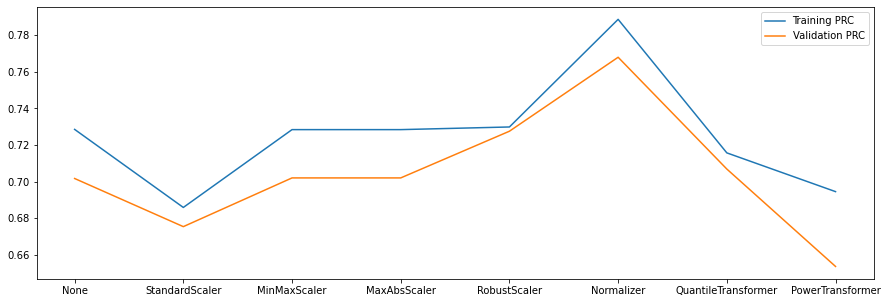

Best preprocessor in training: Normalizer
Best preprocessor in validation: Normalizer


([0.7284796447516373,
  0.6858219883367325,
  0.7283518959235245,
  0.7283518959235245,
  0.7297992920794311,
  0.7886088313009708,
  0.7156447397196853,
  0.6944691560709224],
 [0.701646212239975,
  0.6753358650365536,
  0.701962208861172,
  0.701962208861172,
  0.7274789808648823,
  0.7678999045437706,
  0.7068115080623636,
  0.6535829535505604])

In [121]:
choose_preprocessor(SVC(kernel='sigmoid'))

In [122]:
parameters = {'kernel':['sigmoid'], 'C':[1,10,100,1000], 'gamma':[1,0.1,0.01,0.001,0.0001]}
SVC1clf = GridSearchCV(SVC(), parameters, cv=5,scoring='average_precision',verbose=1)
SVC1clf.fit(Xnormalizer, Ytrain)
SVC1data = pd.DataFrame(SVC1clf.cv_results_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  5.0min finished


In [123]:
SVC1data[['mean_fit_time','params','mean_test_score','std_test_score']]

mean_fit_time                                             params  \
0        2.607826          {'C': 1, 'gamma': 1, 'kernel': 'sigmoid'}   
1        2.641542        {'C': 1, 'gamma': 0.1, 'kernel': 'sigmoid'}   
2        2.762470       {'C': 1, 'gamma': 0.01, 'kernel': 'sigmoid'}   
3        2.280737      {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}   
4        2.081174     {'C': 1, 'gamma': 0.0001, 'kernel': 'sigmoid'}   
5        2.205666         {'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}   
6        2.538880       {'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}   
7        2.647258      {'C': 10, 'gamma': 0.01, 'kernel': 'sigmoid'}   
8        2.595594     {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}   
9        2.269609    {'C': 10, 'gamma': 0.0001, 'kernel': 'sigmoid'}   
10       2.121570        {'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}   
11       2.486691      {'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}   
12       2.496684     {'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'}   
13       2.582826    {'C': 100, 'gamma': 0.001, 'kernel': 'sigmoid'}   
14       2.558695   {'C': 100, 'gamma': 0.0001, 'kernel': 'sigmoid'}   
15       1.968666       {'C': 1000, 'gamma': 1, 'kernel': 'sigmoid'}   
16       3.185737     {'C': 1000, 'gamma': 0.1, 'kernel': 'sigmoid'}   
17       2.533503    {'C': 1000, 'gamma': 0.01, 'kernel': 'sigmoid'}   
18       2.526086   {'C': 1000, 'gamma': 0.001, 'kernel': 'sigmoid'}   
19       2.678945  {'C': 1000, 'gamma': 0.0001, 'kernel': 'sigmoid'}   

    mean_test_score  std_test_score  
0          0.697990        0.018251  
1          0.764178        0.021922  
2          0.761395        0.022310  
3          0.736863        0.029290  
4          0.708575        0.018413  
5          0.701746        0.017908  
6          0.763996        0.021921  
7          0.764961        0.021751  
8          0.761992        0.023095  
9          0.736863        0.029290  
10         0.703342        0.020824  
11         0.763440        0.019911  
12         0.765233        0.021770  
13         0.765241        0.021608  
14         0.762816        0.022555  
15         0.703817        0.021764  
16         0.753899        0.020365  
17         0.765555        0.020104  
18         0.765264        0.021749  
19         0.765095        0.021729

In [124]:
SVC1clf.best_params_

{'C': 1000, 'gamma': 0.01, 'kernel': 'sigmoid'}

0.7436428427896424

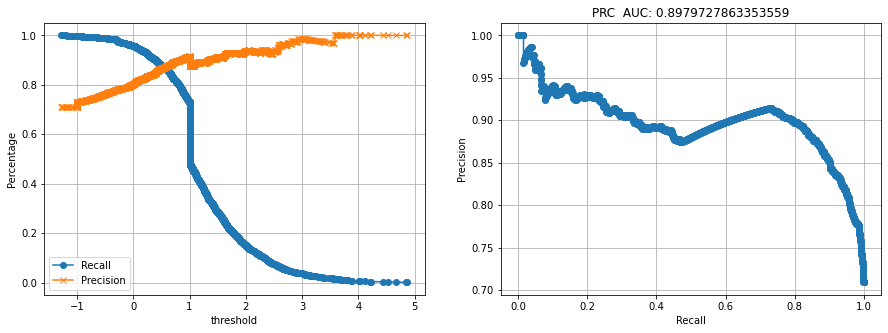

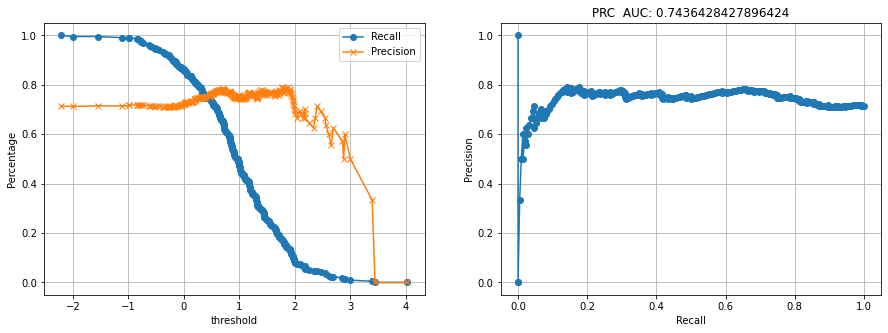

In [125]:
plotPRC(Ytrain,SVC1clf.decision_function(Xnormalizer))
plotPRC(Yv,SVC1clf.decision_function(Xvnormalizer))

In [126]:
parameters = {'kernel':['sigmoid'], 'C':[1000], 'gamma':[0.001,0.0001,0.00001]}
SVC1clf = GridSearchCV(SVC(), parameters, cv=5,scoring='average_precision',verbose=1)
SVC1clf.fit(Xnormalizer, Ytrain)
SVC1data = pd.DataFrame(SVC1clf.cv_results_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   46.9s finished


In [127]:
SVC1data[['mean_fit_time','params','mean_test_score','std_test_score']]

mean_fit_time                                             params  \
0       2.543574   {'C': 1000, 'gamma': 0.001, 'kernel': 'sigmoid'}   
1       2.652565  {'C': 1000, 'gamma': 0.0001, 'kernel': 'sigmoid'}   
2       2.546657   {'C': 1000, 'gamma': 1e-05, 'kernel': 'sigmoid'}   

   mean_test_score  std_test_score  
0         0.765264        0.021749  
1         0.765095        0.021729  
2         0.762815        0.022554

In [128]:
SVC1clf.best_params_

{'C': 1000, 'gamma': 0.001, 'kernel': 'sigmoid'}

In [129]:
parameters = {'kernel':['sigmoid'], 'C':np.arange(500,2000,500), 'gamma':np.arange(0.0005,0.002,0.0005)}
SVC1clf = GridSearchCV(SVC(), parameters, cv=5,scoring='average_precision',verbose=1)
SVC1clf.fit(Xnormalizer, Ytrain)
SVC1data = pd.DataFrame(SVC1clf.cv_results_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.3min finished


In [130]:
SVC1data[['mean_fit_time','params','mean_test_score','std_test_score']]

mean_fit_time                                             params  \
0       2.552503   {'C': 500, 'gamma': 0.0005, 'kernel': 'sigmoid'}   
1       2.526012    {'C': 500, 'gamma': 0.001, 'kernel': 'sigmoid'}   
2       2.514320   {'C': 500, 'gamma': 0.0015, 'kernel': 'sigmoid'}   
3       2.523411  {'C': 1000, 'gamma': 0.0005, 'kernel': 'sigmoid'}   
4       2.490424   {'C': 1000, 'gamma': 0.001, 'kernel': 'sigmoid'}   
5       2.472782  {'C': 1000, 'gamma': 0.0015, 'kernel': 'sigmoid'}   
6       2.517423  {'C': 1500, 'gamma': 0.0005, 'kernel': 'sigmoid'}   
7       2.468001   {'C': 1500, 'gamma': 0.001, 'kernel': 'sigmoid'}   
8       2.465806  {'C': 1500, 'gamma': 0.0015, 'kernel': 'sigmoid'}   

   mean_test_score  std_test_score  
0         0.765116        0.021923  
1         0.765299        0.021897  
2         0.765279        0.021761  
3         0.765219        0.021883  
4         0.765264        0.021749  
5         0.765210        0.021789  
6         0.765336        0.021777  
7         0.765211        0.021741  
8         0.765305        0.021709

In [131]:
SVC1clf.best_params_

{'C': 1500, 'gamma': 0.0005, 'kernel': 'sigmoid'}

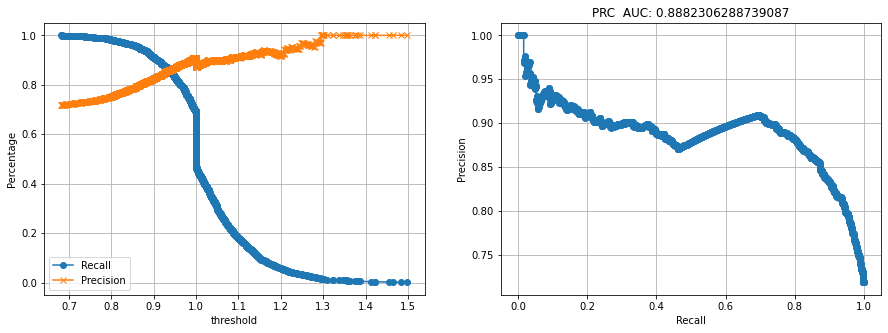

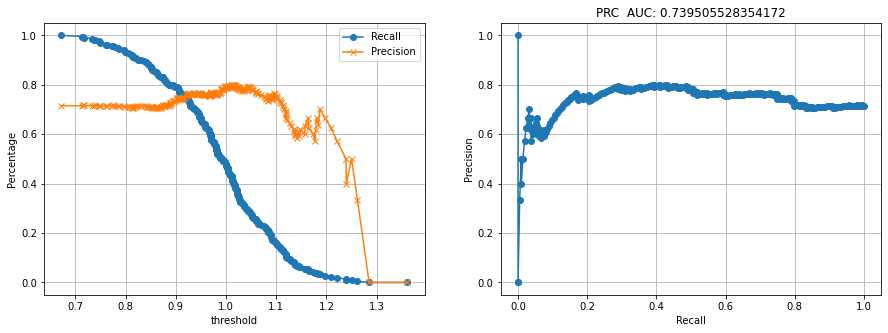

In [132]:
trainPRC = plotPRC(Ytrain,SVC1clf.decision_function(Xnormalizer))
validPRC = plotPRC(Yv,SVC1clf.decision_function(Xvnormalizer))

Best performance from sigmoid SVM was very poor.

In [44]:
SSVMResults = ['C = 1500, gamma = 0.0005','Normalized',trainPRC,validPRC]

RBF SVM

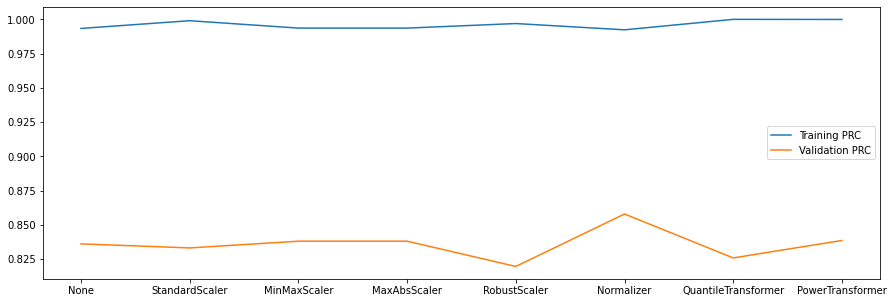

Best preprocessor in training: QuantileTransformer
Best preprocessor in validation: Normalizer


([0.9933478130916119,
  0.998987092423498,
  0.9935935281487851,
  0.9935935281487851,
  0.9969208107999887,
  0.9923358705261995,
  0.9999746742872485,
  0.9999086662420924],
 [0.8361146333094516,
  0.8331367023959337,
  0.8380700849822829,
  0.8380700849822829,
  0.8196293018732728,
  0.8578908009387016,
  0.8258446303617281,
  0.8385950666652451])

In [135]:
choose_preprocessor(SVC(kernel='rbf'))

0.8361146333094516

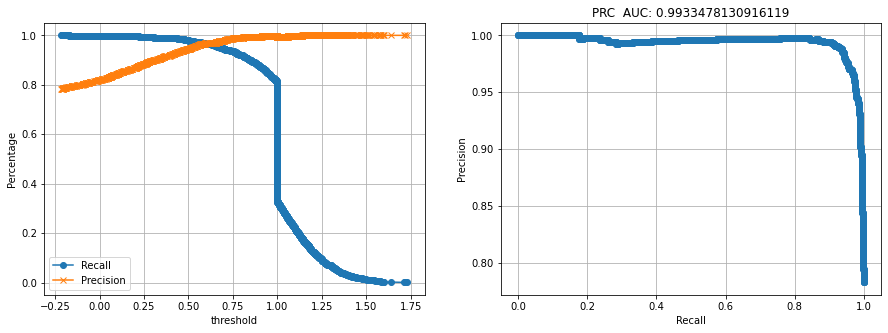

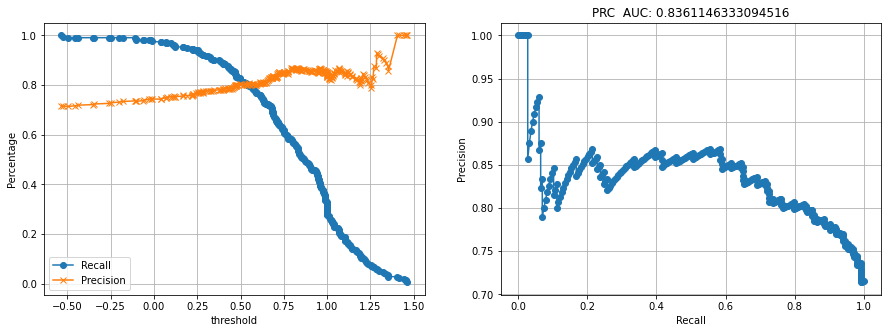

In [136]:
clf = SVC(kernel='rbf')
clf.fit(Xtrain, Ytrain)
plotPRC(Ytrain,clf.decision_function(Xtrain))
plotPRC(Yv,clf.decision_function(Xv))

0.8331367023959337

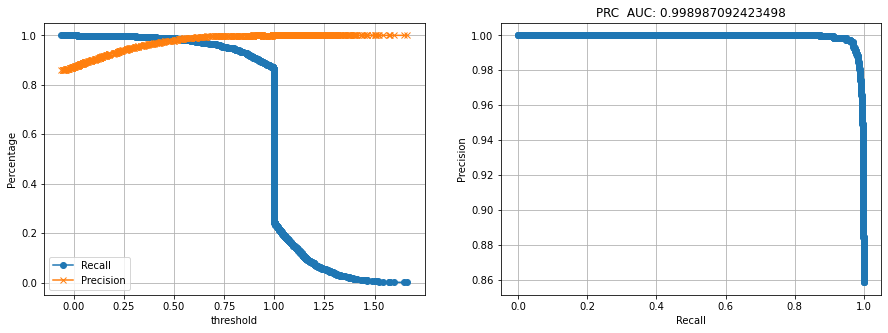

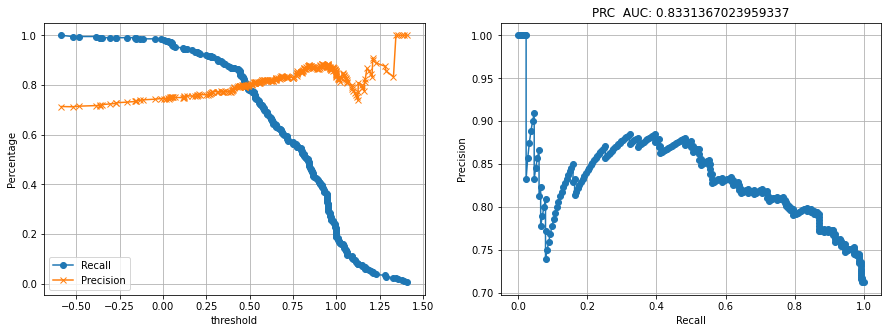

In [138]:
clf = SVC(kernel='rbf')
clf.fit(Xscaled, Ytrain)
plotPRC(Ytrain,clf.decision_function(Xscaled))
plotPRC(Yv,clf.decision_function(Xvscaled))

0.8380700849822829

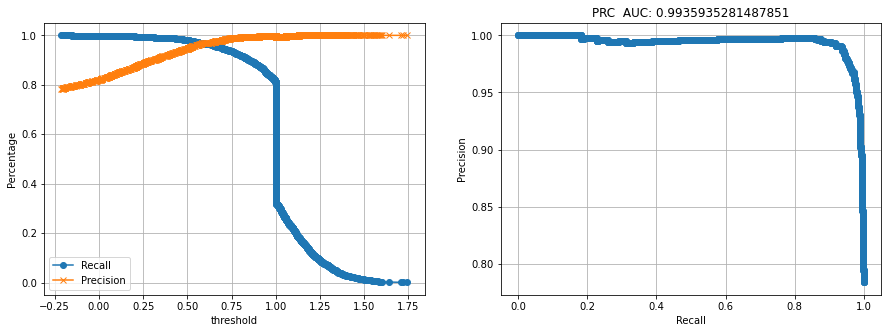

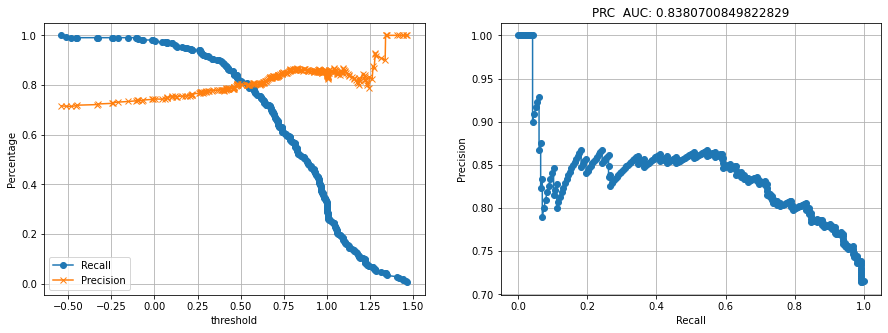

In [139]:
clf = SVC(kernel='rbf')
clf.fit(Xminmaxscaler, Ytrain)
plotPRC(Ytrain,clf.decision_function(Xminmaxscaler))
plotPRC(Yv,clf.decision_function(Xvminmaxscaler))

0.7364462450051033

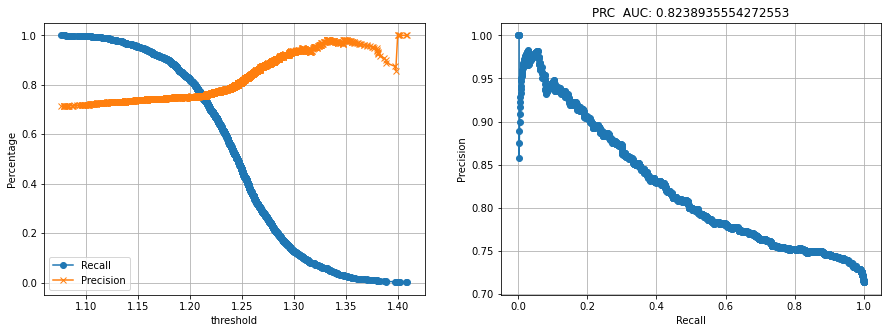

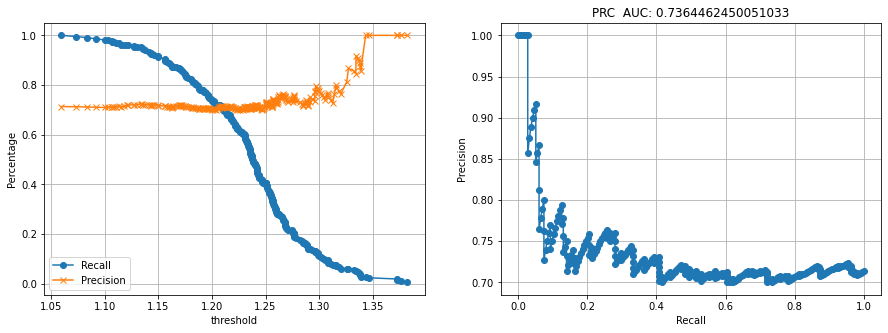

In [140]:
clf = SVC(kernel='rbf')
clf.fit(Xminmaxscaler, Ytrain)
plotPRC(Ytrain,clf.decision_function(Xnormalizer))
plotPRC(Yv,clf.decision_function(Xvnormalizer))

In [141]:
parameters = {'kernel':['rbf'], 'C':[1,10,100,1000]}
SVC1clf = GridSearchCV(SVC(), parameters, cv=5,scoring='average_precision',verbose=1)
SVC1clf.fit(Xminmaxscaler, Ytrain)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.3min finished


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000], 'kernel': ['rbf']},
             scoring='average_precision', verbose=1)

In [142]:
SVC1data = pd.DataFrame(SVC1clf.cv_results_)

In [143]:
SVC1data[['mean_fit_time','params','mean_test_score','std_test_score']]

mean_fit_time                        params  mean_test_score  \
0       2.746324     {'C': 1, 'kernel': 'rbf'}          0.85883   
1       3.323594    {'C': 10, 'kernel': 'rbf'}          0.87804   
2       3.305312   {'C': 100, 'kernel': 'rbf'}          0.87804   
3       3.298699  {'C': 1000, 'kernel': 'rbf'}          0.87804   

   std_test_score  
0        0.013152  
1        0.013726  
2        0.013726  
3        0.013726

In [144]:
SVC1clf.best_params_

{'C': 10, 'kernel': 'rbf'}

0.875078152293861

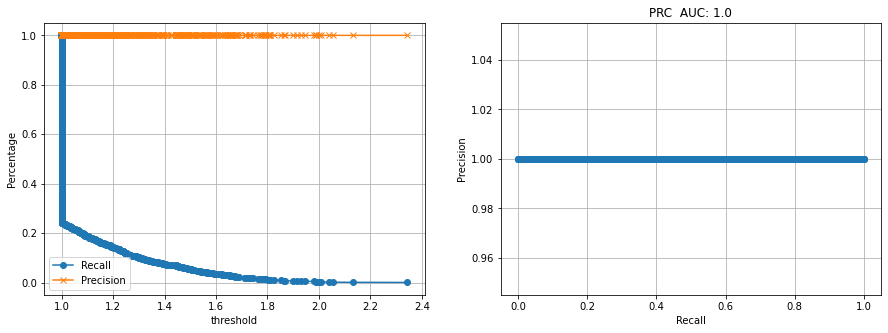

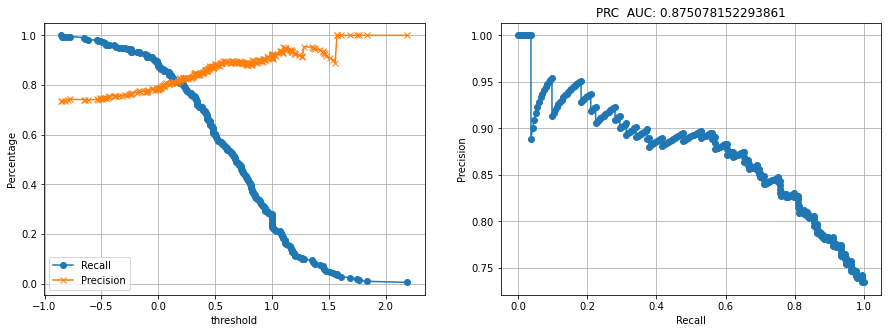

In [145]:
plotPRC(Ytrain,SVC1clf.decision_function(Xminmaxscaler))
plotPRC(Yv,SVC1clf.decision_function(Xvminmaxscaler))

In [146]:
parameters = {'kernel':['rbf'], 'C':[10], 'gamma':np.logspace(-1,-4, num=4)}
SVC2clf = GridSearchCV(SVC(), parameters, cv=5,scoring='average_precision',verbose=1)
SVC2clf.fit(Xminmaxscaler, Ytrain)
SVC2data = pd.DataFrame(SVC2clf.cv_results_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.2min finished


In [147]:
SVC2data[['mean_fit_time','params','mean_test_score','std_test_score']]

mean_fit_time                                       params  \
0       3.355720     {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}   
1       3.280547    {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}   
2       2.474743   {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}   
3       2.634924  {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}   

   mean_test_score  std_test_score  
0         0.881251        0.016746  
1         0.872715        0.014285  
2         0.799320        0.023869  
3         0.767066        0.031050

In [148]:
SVC2clf.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [149]:
parameters = {'kernel':['rbf'], 'C':[10], 'gamma':np.arange(0.02,0.09,0.01)}
SVC2clf = GridSearchCV(SVC(), parameters, cv=5,scoring='average_precision',verbose=1)
SVC2clf.fit(Xminmaxscaler, Ytrain)
SVC2data = pd.DataFrame(SVC2clf.cv_results_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  2.4min finished


In [150]:
SVC2data[['mean_fit_time','params','mean_test_score','std_test_score']]

mean_fit_time                                             params  \
0       3.327765          {'C': 10, 'gamma': 0.02, 'kernel': 'rbf'}   
1       3.323877          {'C': 10, 'gamma': 0.03, 'kernel': 'rbf'}   
2       3.328983  {'C': 10, 'gamma': 0.039999999999999994, 'kern...   
3       3.343363  {'C': 10, 'gamma': 0.049999999999999996, 'kern...   
4       3.329798          {'C': 10, 'gamma': 0.06, 'kernel': 'rbf'}   
5       3.356998  {'C': 10, 'gamma': 0.06999999999999999, 'kerne...   
6       3.332990  {'C': 10, 'gamma': 0.07999999999999999, 'kerne...   

   mean_test_score  std_test_score  
0         0.894814        0.011797  
1         0.903626        0.010421  
2         0.905160        0.010640  
3         0.902435        0.012260  
4         0.896974        0.013890  
5         0.891351        0.015417  
6         0.886346        0.016350

In [151]:
SVC2clf.best_params_

{'C': 10, 'gamma': 0.039999999999999994, 'kernel': 'rbf'}

0.8988693238084444

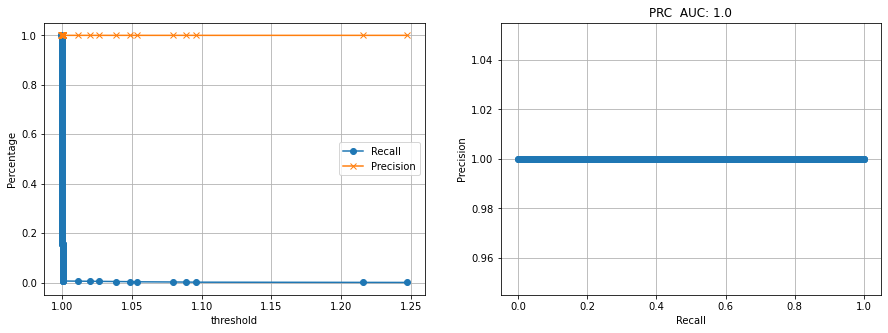

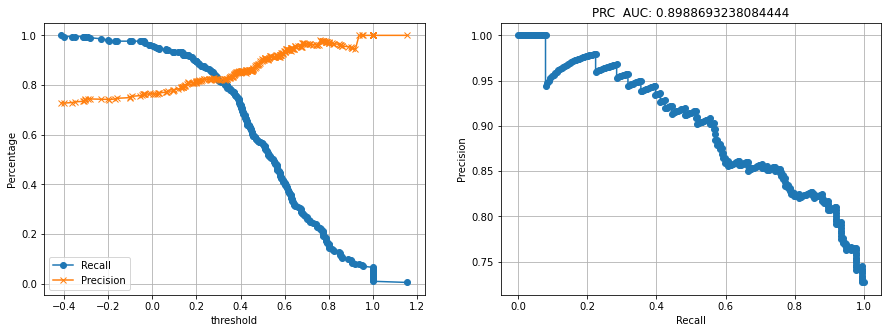

In [152]:
plotPRC(Ytrain,SVC2clf.decision_function(Xminmaxscaler))
plotPRC(Yv,SVC2clf.decision_function(Xvminmaxscaler))

In [153]:
parameters = {'kernel':['rbf'], 'C':np.arange(5,50,5), 'gamma':[0.04]}
SVC2clf = GridSearchCV(SVC(), parameters, cv=5,scoring='average_precision',verbose=1)
SVC2clf.fit(Xminmaxscaler, Ytrain)
SVC2data = pd.DataFrame(SVC2clf.cv_results_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  3.1min finished


In [ ]:
SVC2data[['mean_fit_time','params','mean_test_score','std_test_score']]

In [154]:
SVC2clf.best_params_

{'C': 5, 'gamma': 0.04, 'kernel': 'rbf'}

In [156]:
parameters = {'kernel':['rbf'], 'C':np.arange(0.5,5,0.5), 'gamma':[0.04]}
SVC2clf = GridSearchCV(SVC(), parameters, cv=5,scoring='average_precision',verbose=1)
SVC2clf.fit(Xminmaxscaler, Ytrain)
SVC2data = pd.DataFrame(SVC2clf.cv_results_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  3.1min finished


In [157]:
SVC2data[['mean_fit_time','params','mean_test_score','std_test_score']]

mean_fit_time                                      params  mean_test_score  \
0       3.153184  {'C': 0.5, 'gamma': 0.04, 'kernel': 'rbf'}         0.890807   
1       3.297623  {'C': 1.0, 'gamma': 0.04, 'kernel': 'rbf'}         0.895020   
2       3.369517  {'C': 1.5, 'gamma': 0.04, 'kernel': 'rbf'}         0.902719   
3       3.311266  {'C': 2.0, 'gamma': 0.04, 'kernel': 'rbf'}         0.904907   
4       3.304149  {'C': 2.5, 'gamma': 0.04, 'kernel': 'rbf'}         0.905160   
5       3.328561  {'C': 3.0, 'gamma': 0.04, 'kernel': 'rbf'}         0.905160   
6       3.369218  {'C': 3.5, 'gamma': 0.04, 'kernel': 'rbf'}         0.905160   
7       3.329943  {'C': 4.0, 'gamma': 0.04, 'kernel': 'rbf'}         0.905160   
8       3.324120  {'C': 4.5, 'gamma': 0.04, 'kernel': 'rbf'}         0.905160   

   std_test_score  
0        0.012208  
1        0.012889  
2        0.011841  
3        0.011046  
4        0.010640  
5        0.010640  
6        0.010640  
7        0.010640  
8        0.010640

In [158]:
SVC2clf.best_params_

{'C': 2.5, 'gamma': 0.04, 'kernel': 'rbf'}

In [159]:
parameters = {'kernel':['rbf'], 'C':[3.5], 'gamma':np.arange(0.035,0.045,0.001)}
SVC2clf = GridSearchCV(SVC(), parameters, cv=5,scoring='average_precision',verbose=1)
SVC2clf.fit(Xminmaxscaler, Ytrain)
SVC2data = pd.DataFrame(SVC2clf.cv_results_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.5min finished


In [160]:
SVC2clf.best_params_

{'C': 3.5, 'gamma': 0.036000000000000004, 'kernel': 'rbf'}

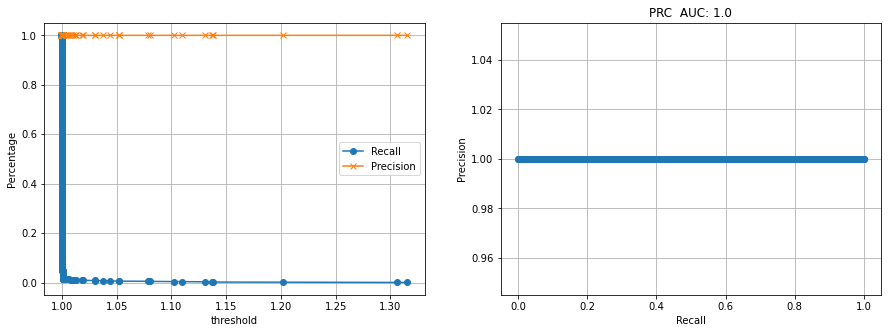

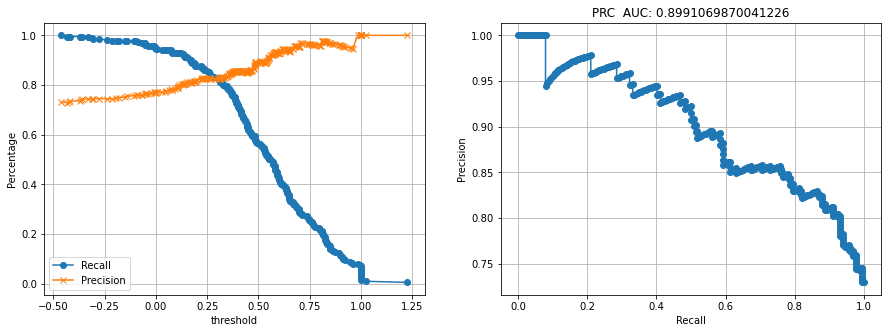

In [162]:
trainPRC = plotPRC(Ytrain,SVC2clf.decision_function(Xminmaxscaler))
validPRC = plotPRC(Yv,SVC2clf.decision_function(Xvminmaxscaler))

In [156]:
parameters = {'kernel':['rbf'], 'C':np.arange(0.5,5,0.5), 'gamma':[0.04]}
SVC2clf = GridSearchCV(SVC(), parameters, cv=5,scoring='average_precision',verbose=1)
SVC2clf.fit(Xminmaxscaler, Ytrain)
SVC2data = pd.DataFrame(SVC2clf.cv_results_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  3.1min finished


In [157]:
SVC2data[['mean_fit_time','params','mean_test_score','std_test_score']]

mean_fit_time                                      params  mean_test_score  \
0       3.153184  {'C': 0.5, 'gamma': 0.04, 'kernel': 'rbf'}         0.890807   
1       3.297623  {'C': 1.0, 'gamma': 0.04, 'kernel': 'rbf'}         0.895020   
2       3.369517  {'C': 1.5, 'gamma': 0.04, 'kernel': 'rbf'}         0.902719   
3       3.311266  {'C': 2.0, 'gamma': 0.04, 'kernel': 'rbf'}         0.904907   
4       3.304149  {'C': 2.5, 'gamma': 0.04, 'kernel': 'rbf'}         0.905160   
5       3.328561  {'C': 3.0, 'gamma': 0.04, 'kernel': 'rbf'}         0.905160   
6       3.369218  {'C': 3.5, 'gamma': 0.04, 'kernel': 'rbf'}         0.905160   
7       3.329943  {'C': 4.0, 'gamma': 0.04, 'kernel': 'rbf'}         0.905160   
8       3.324120  {'C': 4.5, 'gamma': 0.04, 'kernel': 'rbf'}         0.905160   

   std_test_score  
0        0.012208  
1        0.012889  
2        0.011841  
3        0.011046  
4        0.010640  
5        0.010640  
6        0.010640  
7        0.010640  
8        0.010640

In [158]:
SVC2clf.best_params_

{'C': 2.5, 'gamma': 0.04, 'kernel': 'rbf'}

In [194]:
parameters = {'kernel':['rbf'], 'C':[3.5], 'gamma':np.arange(0.03,0.035,0.001)}
SVC2clf = GridSearchCV(SVC(), parameters, cv=5,scoring='average_precision',verbose=1)
SVC2clf.fit(Xminmaxscaler, Ytrain)
SVC2data = pd.DataFrame(SVC2clf.cv_results_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.1min finished


In [195]:
SVC2clf.best_params_

{'C': 3.5, 'gamma': 0.035, 'kernel': 'rbf'}

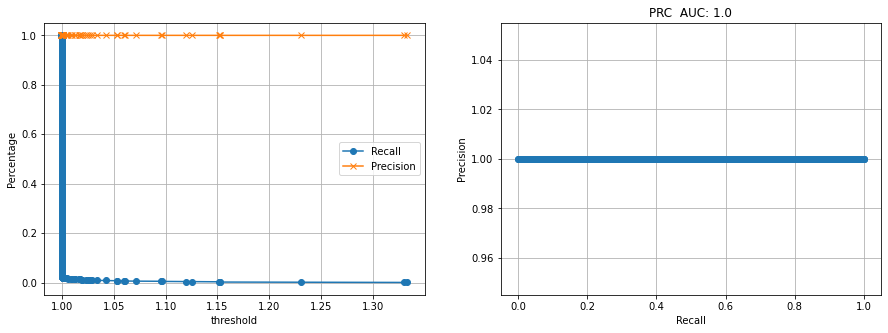

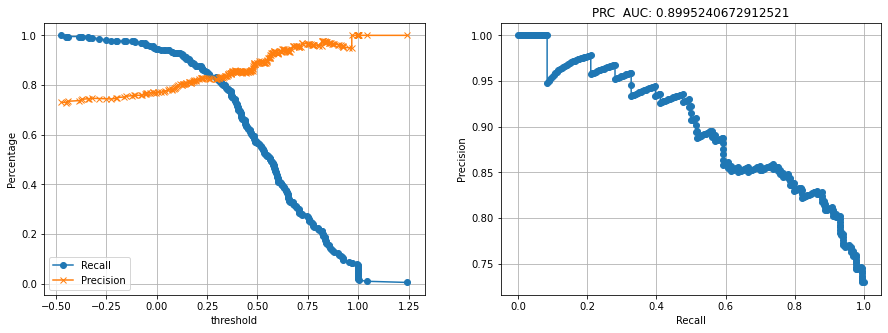

In [196]:
trainPRC = plotPRC(Ytrain,SVC2clf.decision_function(Xminmaxscaler))
validPRC = plotPRC(Yv,SVC2clf.decision_function(Xvminmaxscaler))

In [204]:
parameters = {'kernel':['rbf'], 'C':[3.5], 'gamma':np.arange(0.03485,0.03495,0.00001)}
SVC2clf = GridSearchCV(SVC(), parameters, cv=5,scoring='average_precision',verbose=1)
SVC2clf.fit(Xminmaxscaler, Ytrain)
SVC2data = pd.DataFrame(SVC2clf.cv_results_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  3.7min finished


In [205]:
SVC2clf.best_params_

{'C': 3.5, 'gamma': 0.03485, 'kernel': 'rbf'}

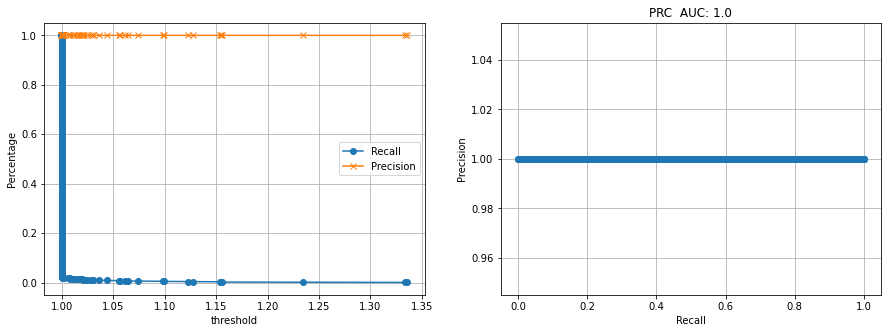

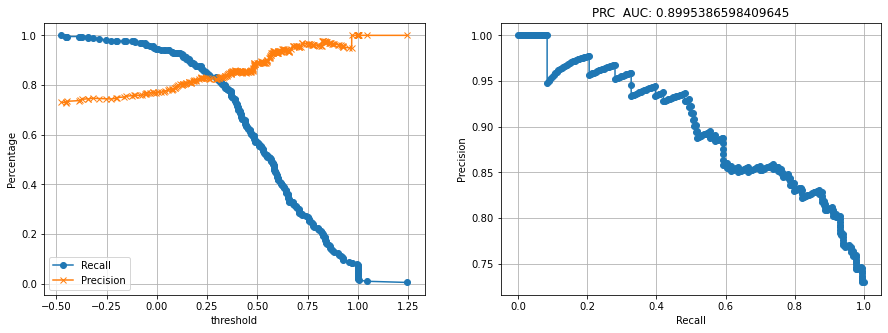

In [217]:
trainPRC = plotPRC(Ytrain,SVC2clf.decision_function(Xminmaxscaler))
validPRC = plotPRC(Yv,SVC2clf.decision_function(Xvminmaxscaler))

RBF SVM gives good results with minmaxscaler preprocessing, and parameters C=3.5 and gamma = 0.03485.

In [45]:
RBFSVMResults = ['C = 3.5, gamma = 0.03485','MinMaxScaler', trainPRC, validPRC]

Poly SVM

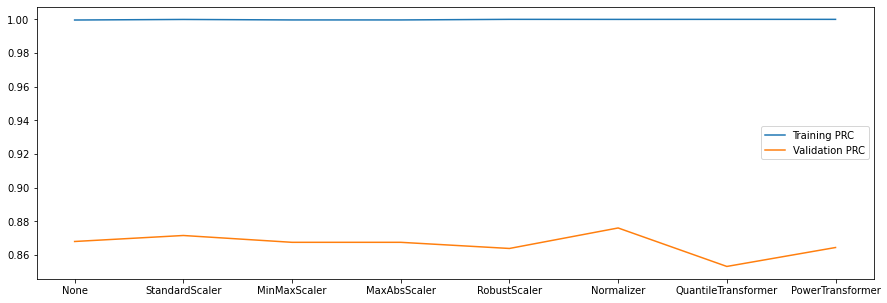

Best preprocessor in training: RobustScaler
Best preprocessor in validation: Normalizer


([0.9996094303858968,
  0.9999417771026373,
  0.9996549304187192,
  0.9996549304187192,
  1.0,
  0.9999737652306568,
  1.0,
  0.9999997242991685],
 [0.8680755599730576,
  0.8716366274919275,
  0.8675848434959803,
  0.8675848434959803,
  0.8639332470803381,
  0.8761050535734942,
  0.8532542626461119,
  0.8644987904297721])

In [164]:
choose_preprocessor(SVC(kernel='poly'))

Accuracy: 0.72


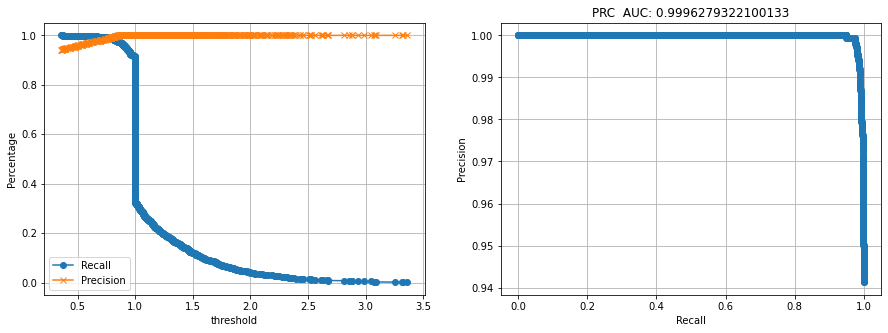

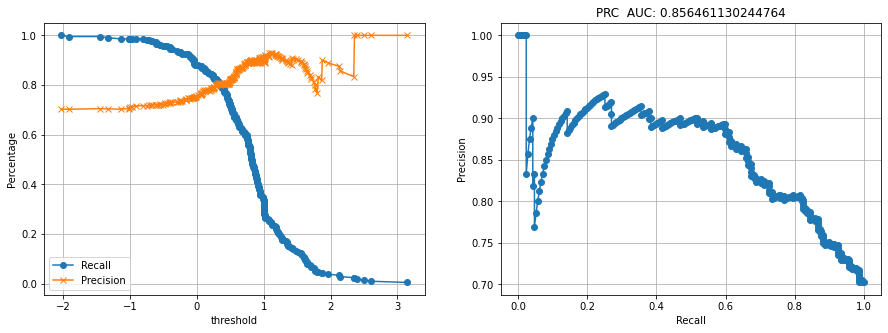

In [59]:
clf = SVC(kernel='poly')
clf.fit(Xtrain, Ytrain)
plotPRC(Ytrain,clf.decision_function(Xtrain))
plotPRC(Yv,clf.decision_function(Xv))
print('Accuracy:', np.mean(Yv == clf.predict(Xv)))

Accuracy: 0.75


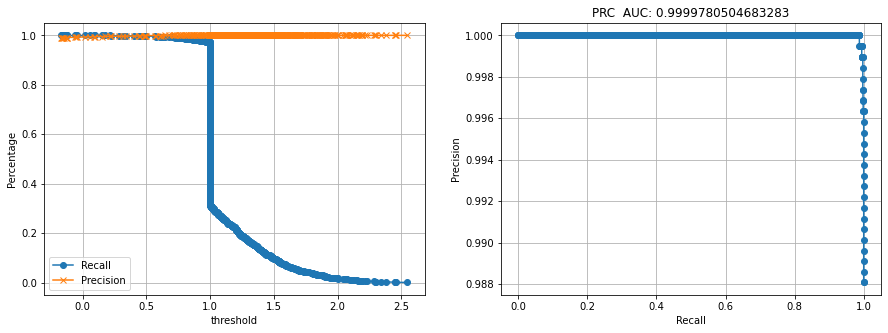

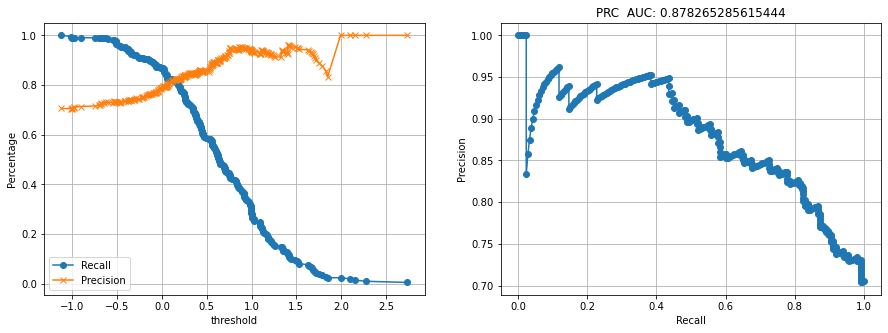

In [62]:
clf = SVC(kernel='poly')
clf.fit(Xnormalizer, Ytrain)
plotPRC(Ytrain,clf.decision_function(Xnormalizer))
plotPRC(Yv,clf.decision_function(Xvnormalizer))
print('Accuracy:', np.mean(Yv == clf.predict(Xvnormalizer)))

In [168]:
parameters = {'kernel':['poly'], 'C':[1], 'degree':np.arange(1,21)}
SVC2clf = GridSearchCV(SVC(), parameters, cv=5,scoring='average_precision',verbose=1)
SVC2clf.fit(Xnormalizer, Ytrain)
SVC2data = pd.DataFrame(SVC2clf.cv_results_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.8min finished


In [172]:
SVC2data[['mean_fit_time','params','mean_test_score','std_test_score']]

mean_fit_time                                    params  mean_test_score  \
0        2.470375   {'C': 1, 'degree': 1, 'kernel': 'poly'}         0.765184   
1        2.663726   {'C': 1, 'degree': 2, 'kernel': 'poly'}         0.827048   
2        3.332757   {'C': 1, 'degree': 3, 'kernel': 'poly'}         0.850522   
3        3.398698   {'C': 1, 'degree': 4, 'kernel': 'poly'}         0.864129   
4        3.419939   {'C': 1, 'degree': 5, 'kernel': 'poly'}         0.875088   
5        3.285135   {'C': 1, 'degree': 6, 'kernel': 'poly'}         0.883217   
6        3.308239   {'C': 1, 'degree': 7, 'kernel': 'poly'}         0.889393   
7        3.368924   {'C': 1, 'degree': 8, 'kernel': 'poly'}         0.893408   
8        3.705368   {'C': 1, 'degree': 9, 'kernel': 'poly'}         0.895889   
9        3.503199  {'C': 1, 'degree': 10, 'kernel': 'poly'}         0.897147   
10       3.391980  {'C': 1, 'degree': 11, 'kernel': 'poly'}         0.897327   
11       3.420849  {'C': 1, 'degree': 12, 'kernel': 'poly'}         0.897932   
12       3.394088  {'C': 1, 'degree': 13, 'kernel': 'poly'}         0.896875   
13       3.519956  {'C': 1, 'degree': 14, 'kernel': 'poly'}         0.895726   
14       3.380818  {'C': 1, 'degree': 15, 'kernel': 'poly'}         0.894824   
15       3.448843  {'C': 1, 'degree': 16, 'kernel': 'poly'}         0.893361   
16       3.402850  {'C': 1, 'degree': 17, 'kernel': 'poly'}         0.891650   
17       3.385813  {'C': 1, 'degree': 18, 'kernel': 'poly'}         0.890097   
18       3.386130  {'C': 1, 'degree': 19, 'kernel': 'poly'}         0.888723   
19       3.624470  {'C': 1, 'degree': 20, 'kernel': 'poly'}         0.886677   

    std_test_score  
0         0.021751  
1         0.018360  
2         0.015634  
3         0.012984  
4         0.010505  
5         0.010010  
6         0.008898  
7         0.008986  
8         0.008620  
9         0.008915  
10        0.009354  
11        0.010075  
12        0.010226  
13        0.010842  
14        0.011119  
15        0.011288  
16        0.011857  
17        0.012187  
18        0.012448  
19        0.013053

In [169]:
SVC2clf.best_params_

{'C': 1, 'degree': 12, 'kernel': 'poly'}

0.9124138714807235

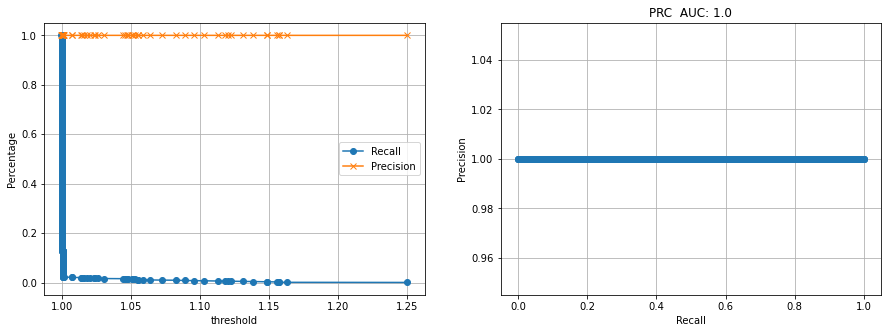

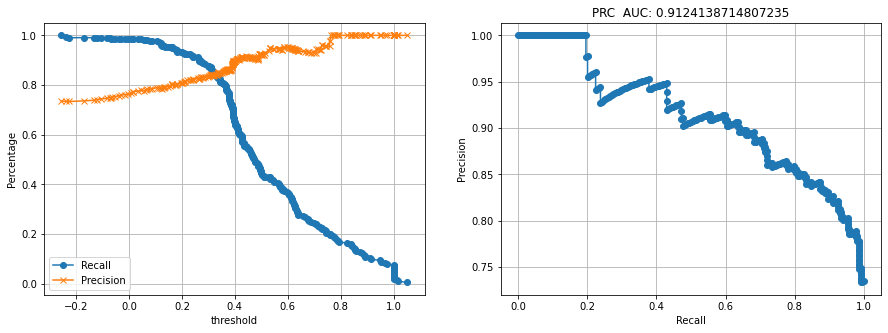

In [170]:
plotPRC(Ytrain,SVC2clf.decision_function(Xnormalizer))
plotPRC(Yv,SVC2clf.decision_function(Xvnormalizer))

In [64]:
parameters = {'kernel':['poly'], 'gamma':[1,0.1,0.01,0.001,0.0001], 'degree':[12]}
refinedSVC2clf = GridSearchCV(SVC(), parameters, cv=5,scoring='average_precision',verbose=1)
refinedSVC2clf.fit(Xnormalizer, Ytrain)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.1min finished


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'degree': [12], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['poly']},
             scoring='average_precision', verbose=1)

In [68]:
refinedSVC2data = pd.DataFrame(refinedSVC2clf.cv_results_)

In [69]:
refinedSVC2data[['mean_fit_time','params','mean_test_score','std_test_score']]

mean_fit_time                                             params  \
0       3.113874       {'degree': 12, 'gamma': 1, 'kernel': 'poly'}   
1       1.917871     {'degree': 12, 'gamma': 0.1, 'kernel': 'poly'}   
2       1.912087    {'degree': 12, 'gamma': 0.01, 'kernel': 'poly'}   
3       1.910691   {'degree': 12, 'gamma': 0.001, 'kernel': 'poly'}   
4       1.913683  {'degree': 12, 'gamma': 0.0001, 'kernel': 'poly'}   

   mean_test_score  std_test_score  
0         0.881270        0.018710  
1         0.708475        0.014876  
2         0.706296        0.000907  
3         0.706296        0.000907  
4         0.706296        0.000907

In [176]:
refinedSVC2clf.best_params_

{'degree': 12, 'gamma': 1, 'kernel': 'poly'}

0.9067073018546958

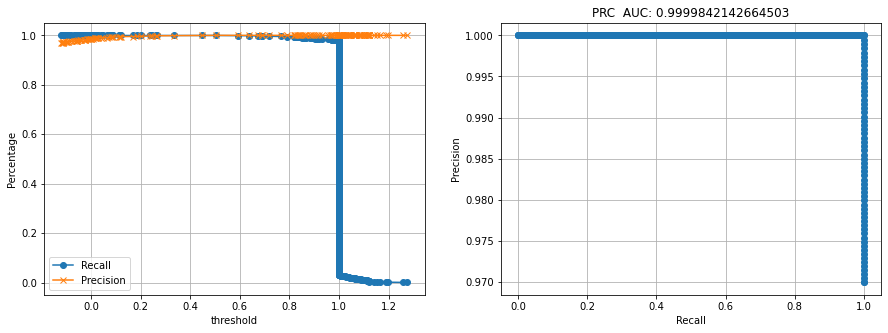

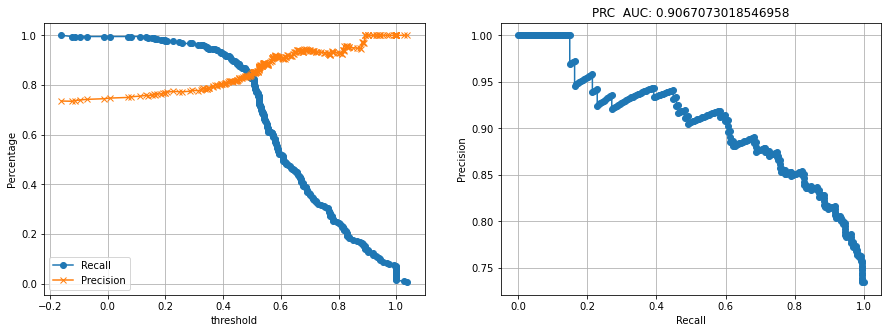

In [177]:
plotPRC(Ytrain,refinedSVC2clf.decision_function(Xnormalizer))
plotPRC(Yv,refinedSVC2clf.decision_function(Xvnormalizer))

In [178]:
parameters = {'kernel':['poly'], 'gamma':[1,10,100], 'degree':[12]}
refinedSVC2clf = GridSearchCV(SVC(), parameters, cv=5,scoring='average_precision',verbose=1)
refinedSVC2clf.fit(Xnormalizer, Ytrain)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   59.7s finished


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'degree': [12], 'gamma': [1, 10, 100],
                         'kernel': ['poly']},
             scoring='average_precision', verbose=1)

In [179]:
refinedSVC2data = pd.DataFrame(refinedSVC2clf.cv_results_)

In [180]:
refinedSVC2data[['mean_fit_time','params','mean_test_score','std_test_score']]

mean_fit_time                                          params  \
0       3.128929    {'degree': 12, 'gamma': 1, 'kernel': 'poly'}   
1       3.286151   {'degree': 12, 'gamma': 10, 'kernel': 'poly'}   
2       3.232109  {'degree': 12, 'gamma': 100, 'kernel': 'poly'}   

   mean_test_score  std_test_score  
0         0.884011        0.013876  
1         0.897933        0.010075  
2         0.897938        0.010076

0.9124138714807235

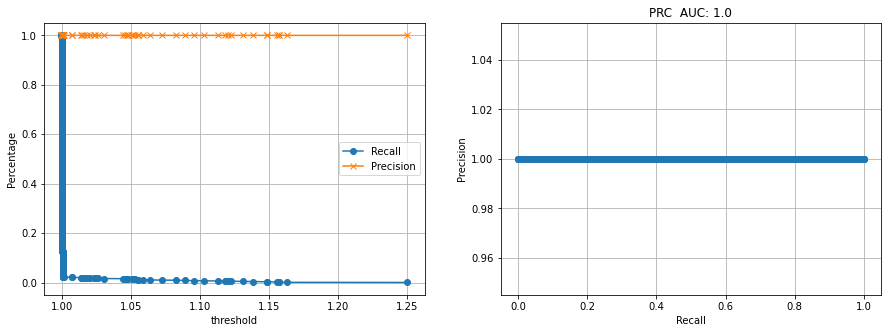

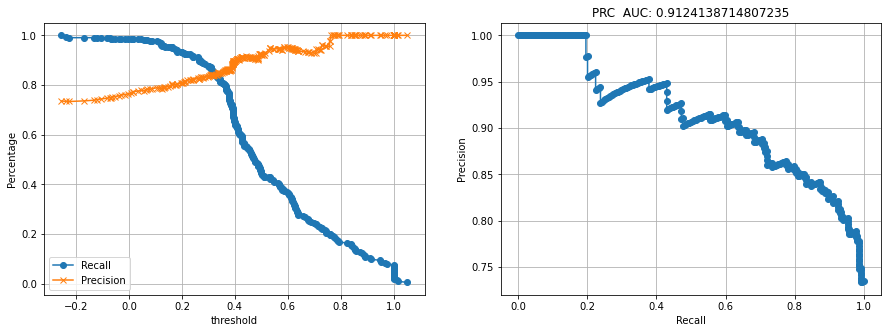

In [181]:
plotPRC(Ytrain,refinedSVC2clf.decision_function(Xnormalizer))
plotPRC(Yv,refinedSVC2clf.decision_function(Xvnormalizer))

In [182]:
parameters = {'kernel':['poly'], 'gamma':np.arange(10,100,10), 'degree':[12]}
refinedSVC2clf = GridSearchCV(SVC(), parameters, cv=5,scoring='average_precision',verbose=1)
refinedSVC2clf.fit(Xnormalizer, Ytrain)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  3.0min finished


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'degree': [12],
                         'gamma': array([10, 20, 30, 40, 50, 60, 70, 80, 90]),
                         'kernel': ['poly']},
             scoring='average_precision', verbose=1)

In [183]:
refinedSVC2data = pd.DataFrame(refinedSVC2clf.cv_results_)

In [184]:
refinedSVC2data[['mean_fit_time','params','mean_test_score','std_test_score']]

mean_fit_time                                         params  \
0       3.271366  {'degree': 12, 'gamma': 10, 'kernel': 'poly'}   
1       3.265792  {'degree': 12, 'gamma': 20, 'kernel': 'poly'}   
2       3.287904  {'degree': 12, 'gamma': 30, 'kernel': 'poly'}   
3       3.233769  {'degree': 12, 'gamma': 40, 'kernel': 'poly'}   
4       3.248628  {'degree': 12, 'gamma': 50, 'kernel': 'poly'}   
5       3.250442  {'degree': 12, 'gamma': 60, 'kernel': 'poly'}   
6       3.228566  {'degree': 12, 'gamma': 70, 'kernel': 'poly'}   
7       3.229564  {'degree': 12, 'gamma': 80, 'kernel': 'poly'}   
8       3.229763  {'degree': 12, 'gamma': 90, 'kernel': 'poly'}   

   mean_test_score  std_test_score  
0         0.897933        0.010075  
1         0.897933        0.010075  
2         0.897934        0.010075  
3         0.897933        0.010075  
4         0.897938        0.010076  
5         0.897934        0.010075  
6         0.897928        0.010078  
7         0.897933        0.010075  
8         0.897932        0.010079

0.9124138714807235

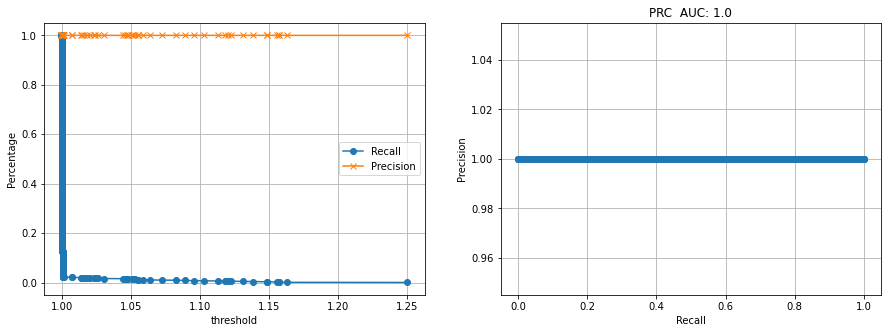

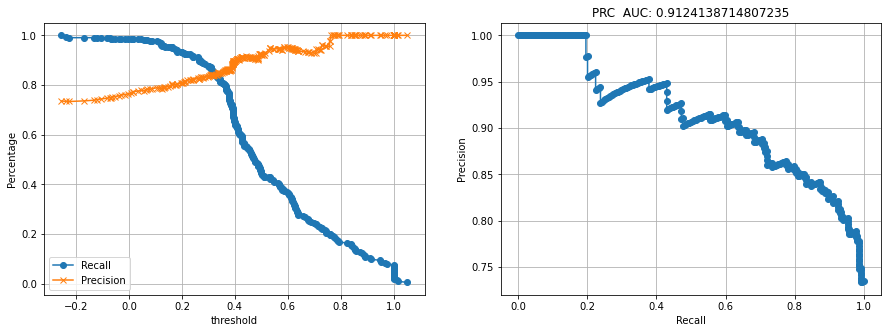

In [185]:
plotPRC(Ytrain,refinedSVC2clf.decision_function(Xnormalizer))
plotPRC(Yv,refinedSVC2clf.decision_function(Xvnormalizer))

In [182]:
parameters = {'kernel':['poly'], 'gamma':np.arange(10,100,10), 'degree':[12]}
refinedSVC2clf = GridSearchCV(SVC(), parameters, cv=5,scoring='average_precision',verbose=1)
refinedSVC2clf.fit(Xnormalizer, Ytrain)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  3.0min finished


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'degree': [12],
                         'gamma': array([10, 20, 30, 40, 50, 60, 70, 80, 90]),
                         'kernel': ['poly']},
             scoring='average_precision', verbose=1)

In [183]:
refinedSVC2data = pd.DataFrame(refinedSVC2clf.cv_results_)

In [184]:
refinedSVC2data[['mean_fit_time','params','mean_test_score','std_test_score']]

mean_fit_time                                         params  \
0       3.271366  {'degree': 12, 'gamma': 10, 'kernel': 'poly'}   
1       3.265792  {'degree': 12, 'gamma': 20, 'kernel': 'poly'}   
2       3.287904  {'degree': 12, 'gamma': 30, 'kernel': 'poly'}   
3       3.233769  {'degree': 12, 'gamma': 40, 'kernel': 'poly'}   
4       3.248628  {'degree': 12, 'gamma': 50, 'kernel': 'poly'}   
5       3.250442  {'degree': 12, 'gamma': 60, 'kernel': 'poly'}   
6       3.228566  {'degree': 12, 'gamma': 70, 'kernel': 'poly'}   
7       3.229564  {'degree': 12, 'gamma': 80, 'kernel': 'poly'}   
8       3.229763  {'degree': 12, 'gamma': 90, 'kernel': 'poly'}   

   mean_test_score  std_test_score  
0         0.897933        0.010075  
1         0.897933        0.010075  
2         0.897934        0.010075  
3         0.897933        0.010075  
4         0.897938        0.010076  
5         0.897934        0.010075  
6         0.897928        0.010078  
7         0.897933        0.010075  
8         0.897932        0.010079

In [186]:
refinedSVC2clf.best_params_

{'degree': 12, 'gamma': 50, 'kernel': 'poly'}

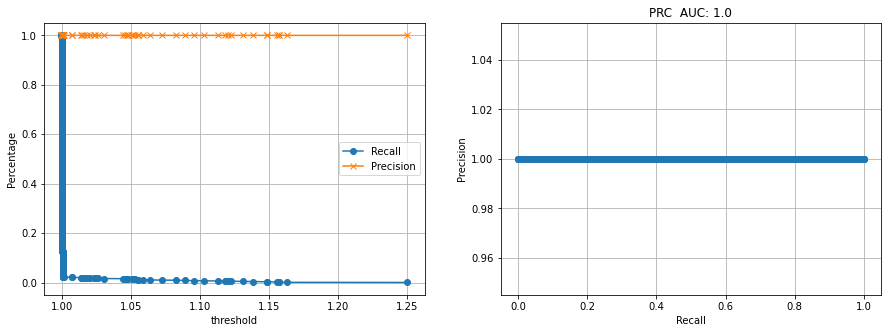

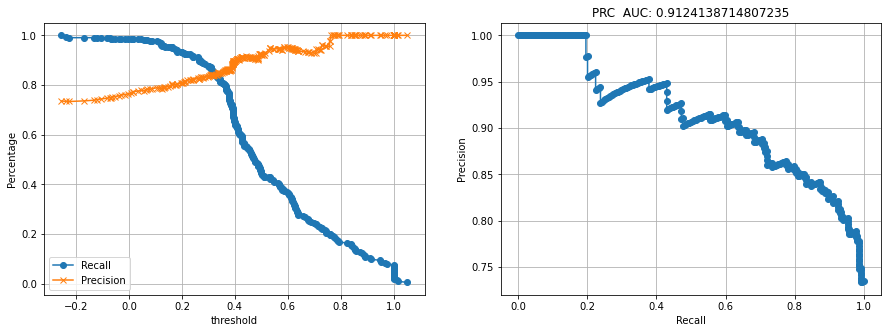

In [188]:
trainPRC = plotPRC(Ytrain,refinedSVC2clf.decision_function(Xnormalizer))
validPRC = plotPRC(Yv,refinedSVC2clf.decision_function(Xvnormalizer))

In [46]:
POLYSVMResults = ['degree = 12, gamma = 50','PowerTransformer', trainPRC, validPRC]

Final results:

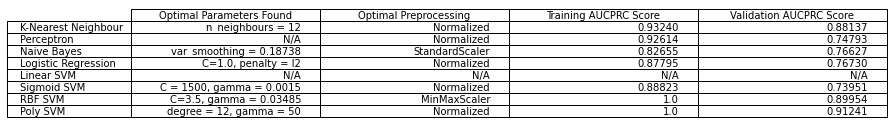

In [70]:
columns = ('Optimal Parameters Found', 'Optimal Preprocessing' , 'Training AUCPRC Score', 'Validation AUCPRC Score')
rows = ['K-Nearest Neighbour','Perceptron','Naive Bayes','Logistic Regression','Linear SVM','Sigmoid SVM','RBF SVM','Poly SVM']

data = [KNNResults,PResults,NBResults,LRResults,LSVMResults,SSVMResults,RBFSVMResults,POLYSVMResults]

fig = plt.figure(figsize=(25,5))
fig.subplots_adjust(left=0.2,top=0.8, wspace=1)

tab= plt.subplot2grid((4,3), (0,0), colspan=2, rowspan=2)
tab.table(cellText=data,
          rowLabels=rows,
          colLabels=columns, loc="upper center")

tab.axis("off")
plt.show()

Cross validation results of my two best models:

In [220]:
AUCROC,AUCPRC,ACCURACY = [],[],[]
for i, (train_index,test_index) in enumerate(skf.split(Xpowertransformer,Ytrain)):
    X_train, X_test = Xminmaxscaler[train_index], Xminmaxscaler[test_index]
    Y_train, Y_test = Ytrain[train_index], Ytrain[test_index]
    clf = SVC(kernel='rbf',C=5,gamma=0.03485)
    clf = clf.fit(X_train, Y_train)
    Z = clf.predict(X_test)
    prediction_scores = clf.decision_function(X_test)
    roc_tr = ROC(Y_test,prediction_scores,'Training')
    pr_tr = PRC(Y_test,prediction_scores,'Training')
    AUCROC.append(roc_tr)
    AUCPRC.append(pr_tr)
    ACCURACY.append(np.mean(Z==Y_test))
    print('Fold: '+str(i+1))
    print('Accuracy:',np.mean(Z==Y_test))
    print('ROC Training AUC: '+str(roc_tr))
    print('PRC Training AUC: '+str(pr_tr))
    print('............................................')
    
print('\nAccuracy Mean:',np.mean(ACCURACY))
print('ROC Mean AUC',np.mean(AUCROC))
print('ROC Stdev AUC',np.std(AUCROC))
print('PRC Mean AUC',np.mean(AUCPRC))
print('PRC Stdev AUC',np.std(AUCPRC))

Fold: 1
Accuracy: 0.7962962962962963
ROC Training AUC: 0.821522309711286
PRC Training AUC: 0.9060823686967788
............................................
Fold: 2
Accuracy: 0.7814814814814814
ROC Training AUC: 0.8200861684742238
PRC Training AUC: 0.9142151147067274
............................................
Fold: 3
Accuracy: 0.7537037037037037
ROC Training AUC: 0.8185344756433748
PRC Training AUC: 0.9180093092766222
............................................
Fold: 4
Accuracy: 0.7666666666666667
ROC Training AUC: 0.7909176447283712
PRC Training AUC: 0.8983745893529829
............................................
Fold: 5
Accuracy: 0.7777777777777778
ROC Training AUC: 0.7821875
PRC Training AUC: 0.8891613379402801
............................................

Accuracy Mean: 0.7751851851851852
ROC Mean AUC 0.8066496197114512
ROC Stdev AUC 0.016666600665125167
PRC Mean AUC 0.9051685439946782
PRC Stdev AUC 0.010487604450985245


In [71]:
AUCROC,AUCPRC,ACCURACY = [],[],[]
for i, (train_index,test_index) in enumerate(skf.split(Xnormalizer,Ytrain)):
    X_train, X_test = Xnormalizer[train_index], Xnormalizer[test_index]
    Y_train, Y_test = Ytrain[train_index], Ytrain[test_index]
    clf = SVC(kernel='poly',degree=12,gamma=50)
    clf = clf.fit(X_train, Y_train)
    Z = clf.predict(X_test)
    prediction_scores = clf.decision_function(X_test)
    roc_tr = ROC(Y_test,prediction_scores,'Training')
    pr_tr = PRC(Y_test,prediction_scores,'Training')
    AUCROC.append(roc_tr)
    AUCPRC.append(pr_tr)
    ACCURACY.append(np.mean(Z==Y_test))
    print('Fold: '+str(i+1))
    print('Accuracy:',np.mean(Z==Y_test))
    print('ROC Training AUC: '+str(roc_tr))
    print('PRC Training AUC: '+str(pr_tr))
    print('............................................')
    
print('\nAccuracy Mean:',np.mean(ACCURACY))
print('ROC Mean AUC',np.mean(AUCROC))
print('ROC Stdev AUC',np.std(AUCROC))
print('PRC Mean AUC',np.mean(AUCPRC))
print('PRC Stdev AUC',np.std(AUCPRC))

Fold: 1
Accuracy: 0.7425925925925926
ROC Training AUC: 0.7875666485085591
PRC Training AUC: 0.8855514532727964
............................................
Fold: 2
Accuracy: 0.7444444444444445
ROC Training AUC: 0.81042935670777
PRC Training AUC: 0.9125407031286756
............................................
Fold: 3
Accuracy: 0.7425925925925926
ROC Training AUC: 0.8090757523234123
PRC Training AUC: 0.8990284272342601
............................................
Fold: 4
Accuracy: 0.7444444444444445
ROC Training AUC: 0.8128272251308901
PRC Training AUC: 0.9060772361427708
............................................
Fold: 5
Accuracy: 0.7277777777777777
ROC Training AUC: 0.7687719530784016
PRC Training AUC: 0.8770592172315165
............................................

Accuracy Mean: 0.7403703703703703
ROC Mean AUC 0.7977341871498067
ROC Stdev AUC 0.017086767222731926
PRC Mean AUC 0.896051407402004
PRC Stdev AUC 0.013055489931594987


From these results, the rbf kernel SVM gives the highest accuracy at a mean of 0.775.

Question 4:

i. Reduce the number of dimensions of the data using PCA to 2 and plot a scatter plot of
the training data. What are your observations about the data based on data?

In [74]:
from sklearn.decomposition import PCA
scaler = StandardScaler()
scalerXtrain = scaler.fit_transform(Xtrain)

(2700, 784)
(2700, 2)


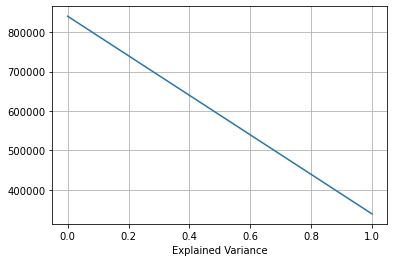

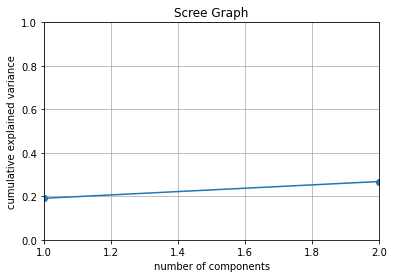

In [75]:
from sklearn.decomposition import PCA #import PCA
pca = PCA(n_components=2)
pca.fit(Xtrain) #training PCA
projected = pca.transform(Xtrain) #projecting the data onto Principal components
print(Xtrain.shape)
print(projected.shape)
plt.plot(pca.explained_variance_); plt.grid();
plt.xlabel('Explained Variance')
plt.figure()
plt.plot(np.arange(len(pca.explained_variance_ratio_))+1,np.cumsum(pca.explained_variance_ratio_),'o-') #plot the scree graph
plt.axis([1,len(pca.explained_variance_ratio_),0,1])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('Scree Graph')
plt.grid()
plt.show()

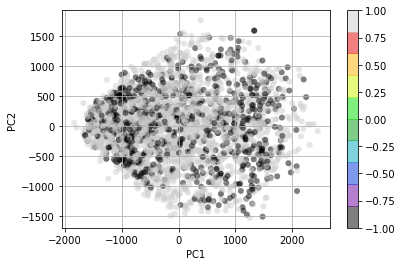

In [76]:
i1 = 0 #first principal component
i2 = 1 #second principal component
plt.scatter(projected[:, i1], projected[:, i2],
            c=Ytrain, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10));
plt.grid()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar();
plt.show()

Observations: Data seems very inseparable, but there is a high density of -1.0 class on the left hand side.

ii. Plot the scree graph of PCA and find the number of dimensions that explain 95%
variance in the training set.

(2700, 784)
(2700, 498)


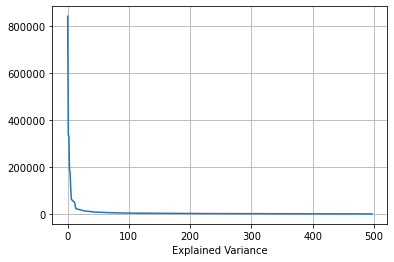

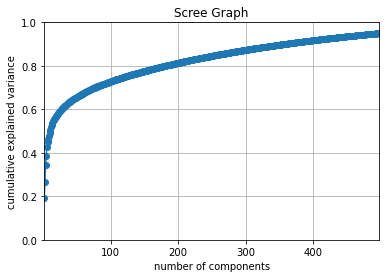

In [77]:
pca = PCA(0.95)
pca.fit(Xtrain) #training PCA
projected = pca.transform(Xtrain) #projecting the data onto Principal components
print(Xtrain.shape)
print(projected.shape)
plt.plot(pca.explained_variance_); plt.grid();
plt.xlabel('Explained Variance')
plt.figure()
plt.plot(np.arange(len(pca.explained_variance_ratio_))+1,np.cumsum(pca.explained_variance_ratio_),'o-') #plot the scree graph
plt.axis([1,len(pca.explained_variance_ratio_),0,1])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('Scree Graph')
plt.grid()
plt.show()

In [78]:
print('Number of dimensions that account for 95% of variance:',len(pca.explained_variance_ratio_)+1)

Number of dimensions that account for 95% of variance: 499


iii. Reduce the number of dimensions of the data using PCA and perform classification.
What is the (optimal) cross-validation performance of a Kernelized SVM classification
with PCA? Remember to perform hyperparameter optimization!

In [79]:
def PCA_projector(factor,xtrain,xvtrain):
    pca = PCA(factor)
    pca.fit(xtrain) #training PCA
    projected = pca.transform(xtrain) #projecting the data onto Principal components
    vprojected = pca.transform(xvtrain)
    return projected,vprojected

In [100]:
data = []
for factor in range(40,100):
    info = []
    projected,vprojected = PCA_projector(factor/100,Xminmaxscaler,Xvminmaxscaler)
    clf = SVC(kernel='rbf',C=5,gamma=0.03485)
    clf.fit(projected,Ytrain)
    info.append(factor)
    PRC(Ytrain,clf.decision_function(projected))
    info.append(PRC(Yv,clf.decision_function(vprojected)))
    info.append(np.mean(clf.predict(projected) == Ytrain))
    info.append(np.mean(clf.predict(vprojected) == Yv))
    data.append(info)

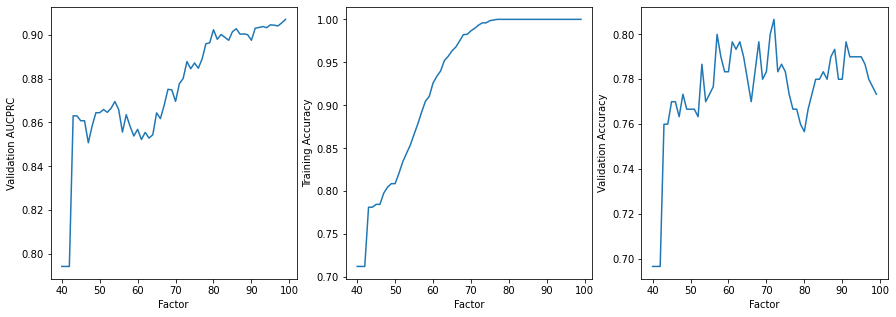

In [101]:
data1 = np.array(data)
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(data1.T[0],data1.T[1])
plt.xlabel('Factor')
plt.ylabel('Validation AUCPRC')
plt.subplot(1,3,2)
plt.plot(data1.T[0],data1.T[2])
plt.xlabel('Factor')
plt.ylabel('Training Accuracy')
plt.subplot(1,3,3)
plt.plot(data1.T[0],data1.T[3])
plt.xlabel('Factor')
plt.ylabel('Validation Accuracy')
plt.show()

In [113]:
print('Factor giving highest validation AUCPRC:',data1.T[0][np.argmax(data1.T[1])])
print('Factor giving highest validation accuracy:',data1.T[0][np.argmax(data1.T[3])])
print('Validation accuracy at this factor:',data1.T[3][np.argmax(data1.T[3])])
print('Training accuracy at this factor:',data1.T[2][np.argmax(data1.T[3])])

Factor giving highest validation AUCPRC: 99.0
Factor giving highest validation accuracy: 72.0
Validation accuracy at this factor: 0.8066666666666666
Training accuracy at this factor: 0.9933333333333333


In [88]:
# data = []
# for factor in range(40,100):
#     info = []
#     projected,vprojected = PCA_projector(factor/100,Xpowertransformer,Xvpowertransformer)
#     clf = SVC(kernel='poly',degree=12)
#     clf.fit(projected,Ytrain)
#     info.append(factor)
#     PRC(Ytrain,clf.decision_function(projected))
#     info.append(PRC(Yv,clf.decision_function(vprojected)))
#     info.append(np.mean(clf.predict(projected) == Ytrain))
#     info.append(np.mean(clf.predict(vprojected) == Yv))
#     data.append(info)

In [104]:
# data2 = np.array(data)
# fig = plt.figure(figsize=(15,5))
# plt.subplot(1,3,1)
# plt.plot(data2.T[0],data2.T[1])
# plt.xlabel('Factor')
# plt.ylabel('Validation AUCPRC')
# plt.subplot(1,3,2)
# plt.plot(data2.T[0],data2.T[2])
# plt.xlabel('Factor')
# plt.ylabel('Training Accuracy')
# plt.subplot(1,3,3)
# plt.plot(data2.T[0],data2.T[3])
# plt.xlabel('Factor')
# plt.ylabel('Validation Accuracy')
# plt.show()

In [114]:
# print(data2.T[0][np.argmax(data2.T[1])])
# print(data2.T[0][np.argmax(data2.T[3])])

Training accuracy: 0.9933333333333333
Validation accuracy: 0.8066666666666666


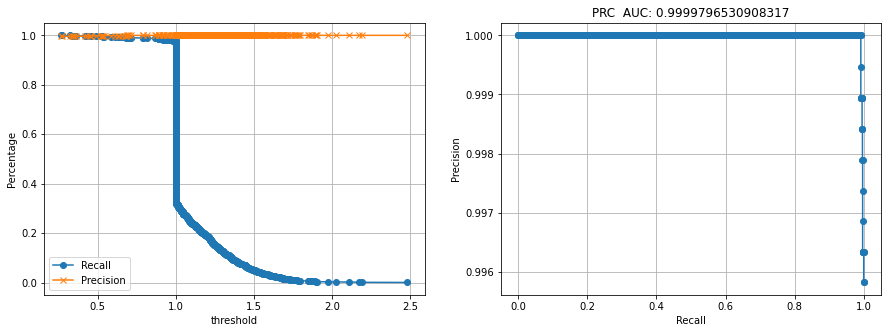

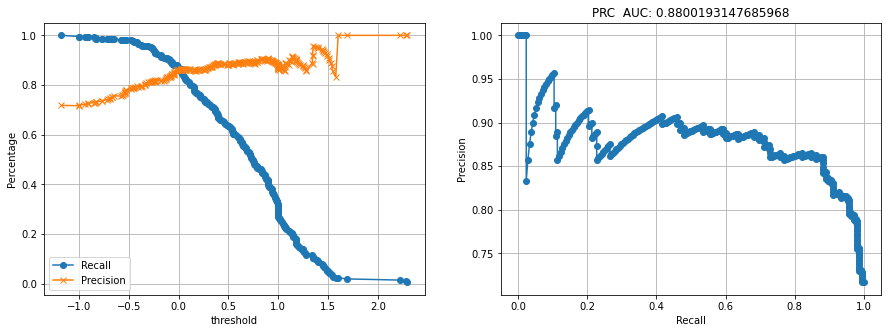

In [115]:
projected,vprojected = PCA_projector(0.72,Xminmaxscaler,Xvminmaxscaler)
clf = SVC(kernel='rbf',C=5,gamma=0.03485)
clf.fit(projected,Ytrain)
trainPRC = plotPRC(Ytrain,clf.decision_function(projected))
validPRC = plotPRC(Yv,clf.decision_function(vprojected))
print('Training accuracy:',np.mean(clf.predict(projected) == Ytrain))
print('Validation accuracy:',np.mean(clf.predict(vprojected) == Yv))

0.01
Training accuracy: 0.8762962962962964
Validation accuracy: 0.7766666666666666
-----------------------------------------------------------------------------------------------------------------------------
0.02
Training accuracy: 0.9614814814814815
Validation accuracy: 0.7866666666666666
-----------------------------------------------------------------------------------------------------------------------------
0.03
Training accuracy: 0.9874074074074074
Validation accuracy: 0.7966666666666666
-----------------------------------------------------------------------------------------------------------------------------
0.04
Training accuracy: 0.9974074074074074
Validation accuracy: 0.8033333333333333
-----------------------------------------------------------------------------------------------------------------------------
0.05
Training accuracy: 0.9996296296296296
Validation accuracy: 0.7833333333333333
---------------------------------------------------------------------------------

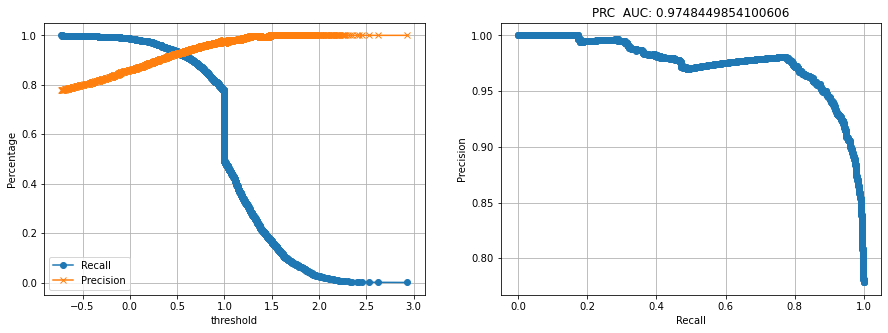

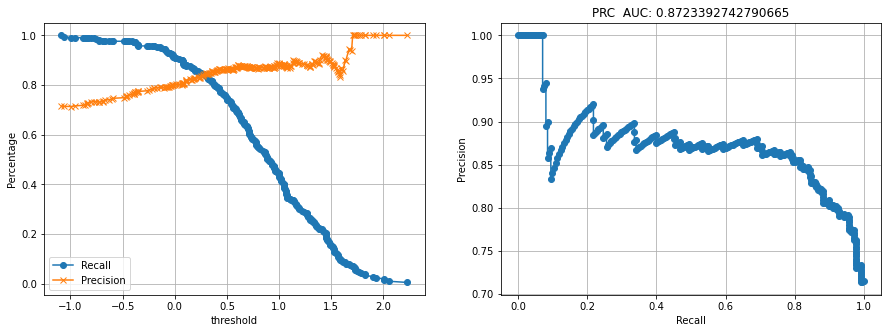

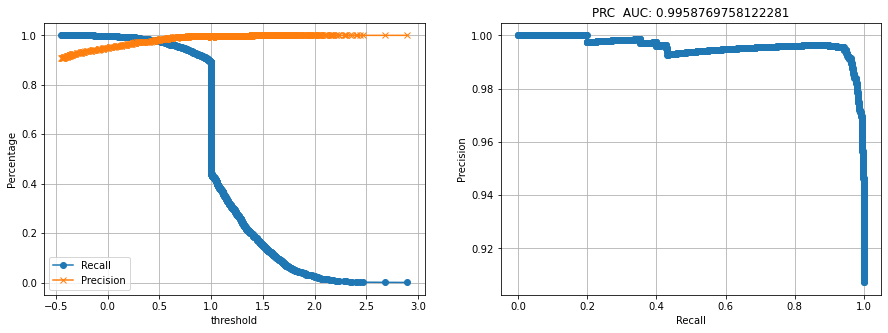

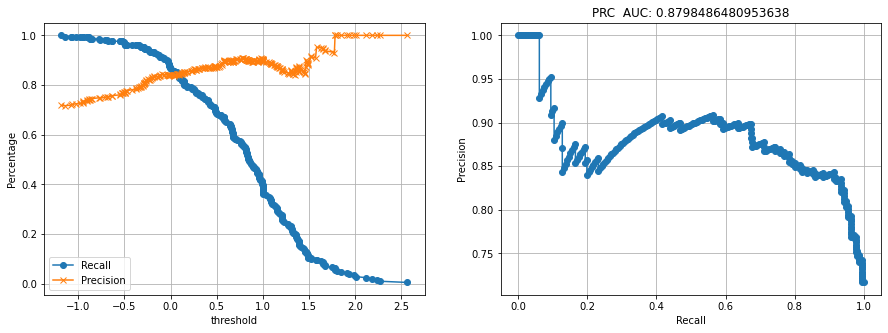

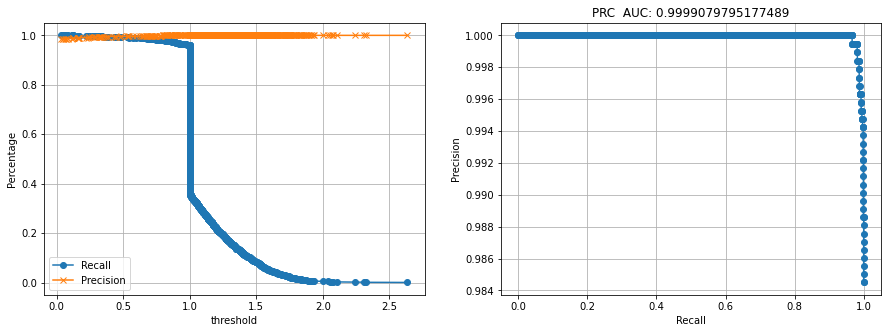

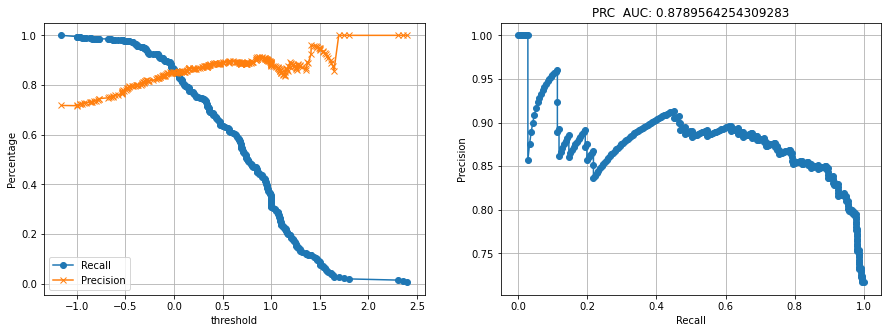

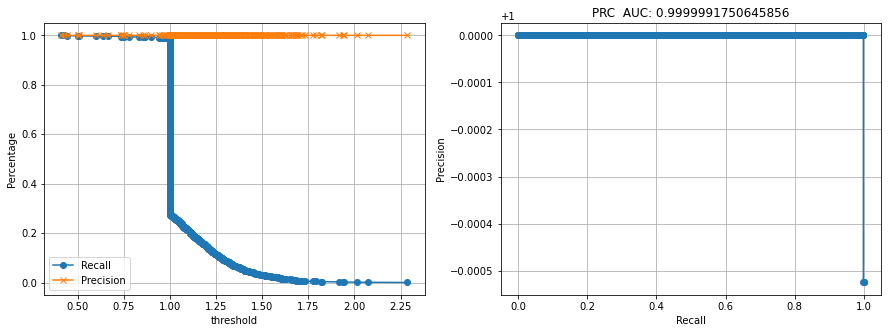

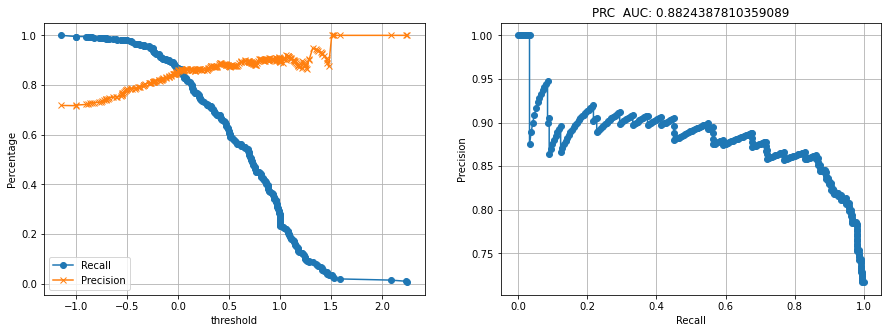

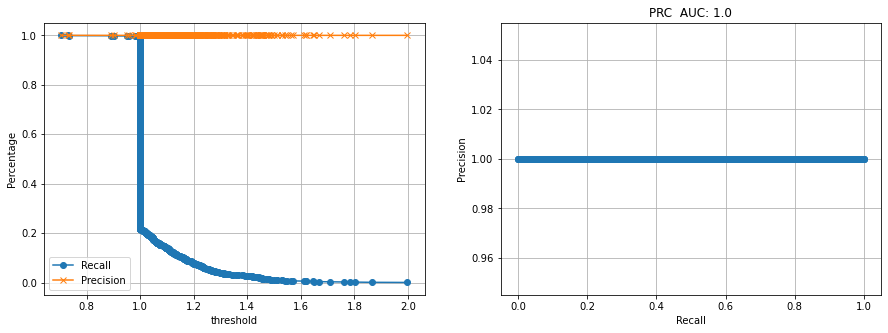

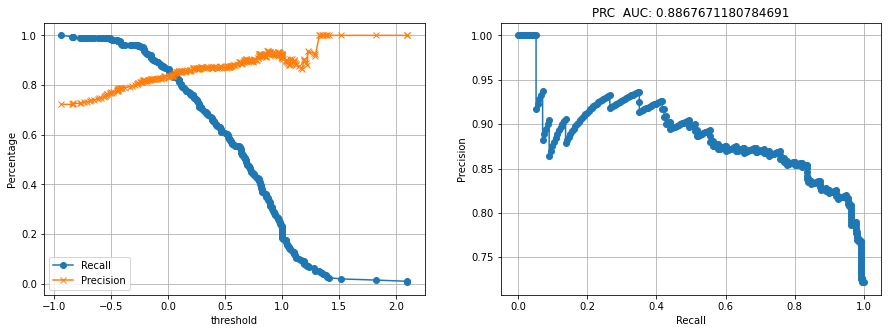

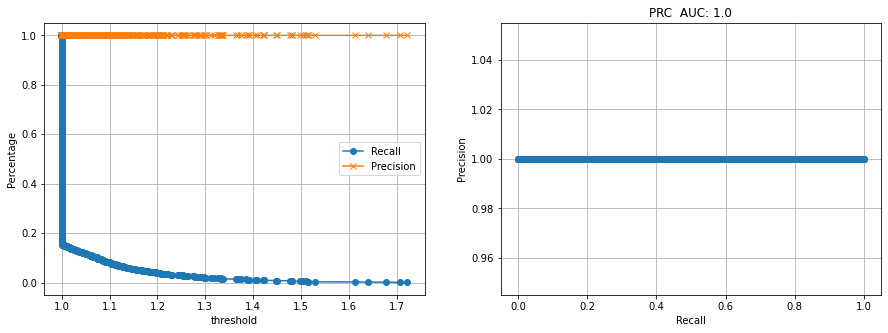

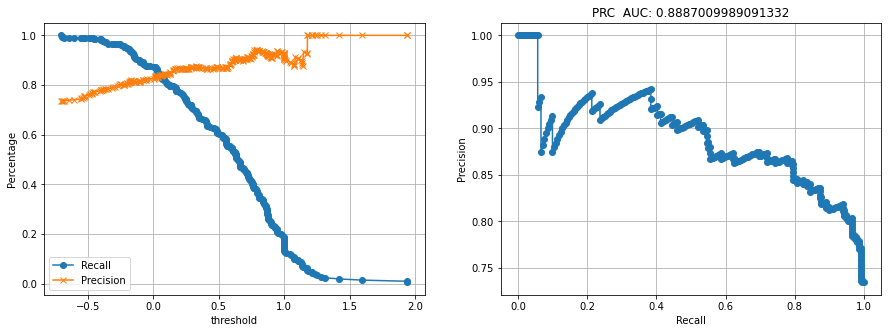

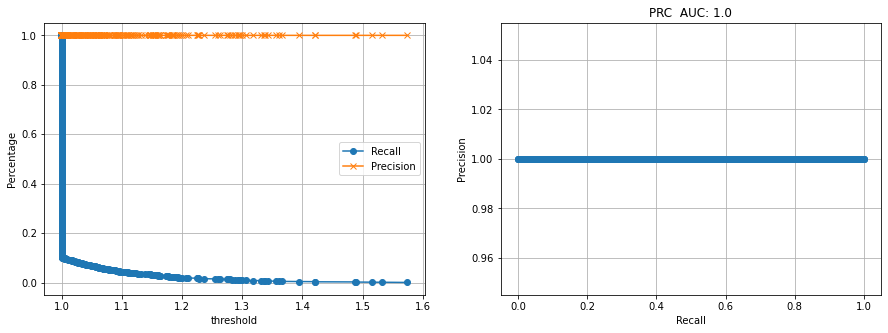

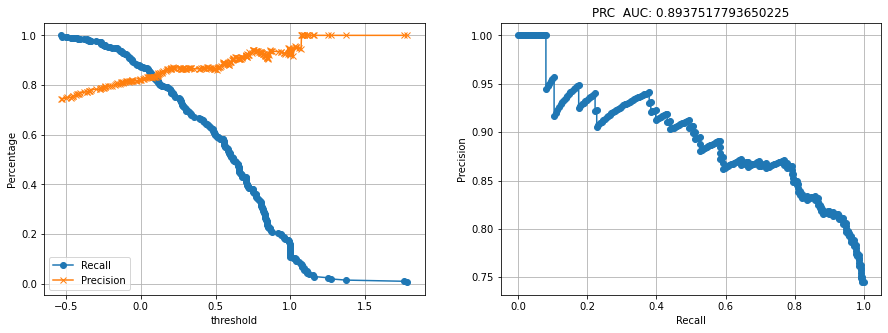

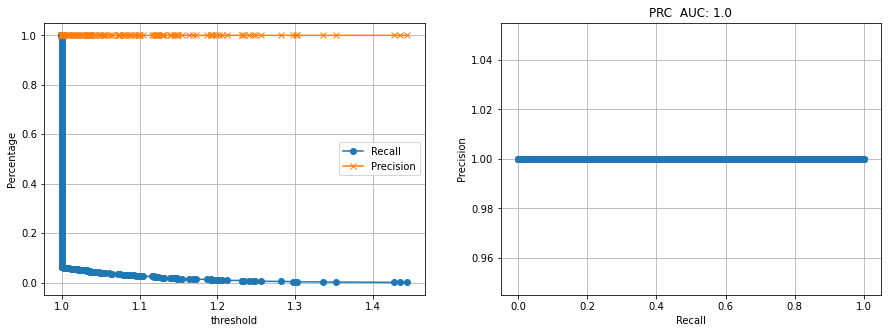

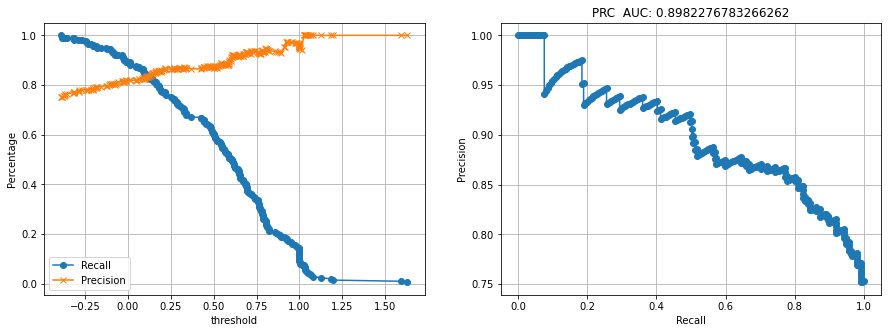

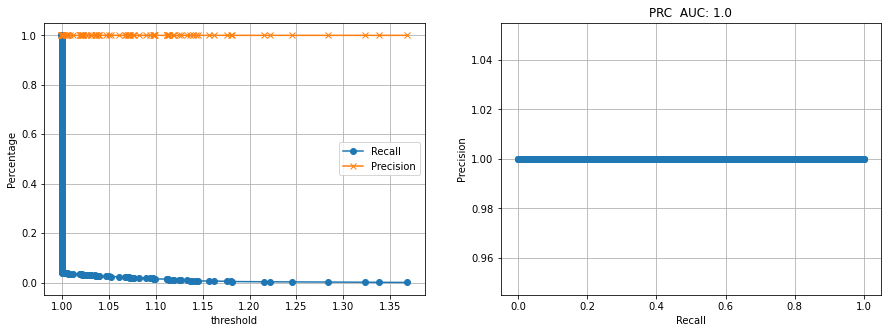

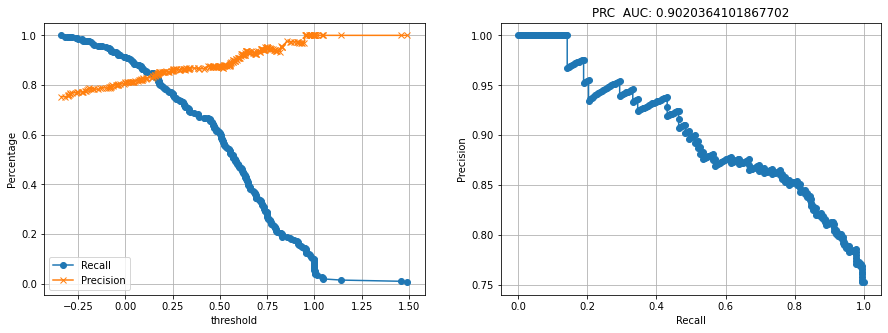

In [120]:
projected,vprojected = PCA_projector(0.72,Xminmaxscaler,Xvminmaxscaler)
for gamma in np.arange(0.01,0.1,0.01):
    print('Gamma:,'gamma)
    clf = SVC(kernel='rbf',C=5,gamma=gamma)
    clf.fit(projected,Ytrain)
    trainPRC = plotPRC(Ytrain,clf.decision_function(projected))
    validPRC = plotPRC(Yv,clf.decision_function(vprojected))
    print('Training accuracy:',np.mean(clf.predict(projected) == Ytrain))
    print('Validation accuracy:',np.mean(clf.predict(vprojected) == Yv))
    print('-----------------------------------------------------------------------------------------------------------------------------')

In [123]:
results = []
projected,vprojected = PCA_projector(0.72,Xminmaxscaler,Xvminmaxscaler)
for gamma in np.arange(0.035,0.042,0.0001):
    data = []
    print('Gamma:',gamma)
    data.append(gamma)
    clf = SVC(kernel='rbf',C=5,gamma=gamma)
    clf.fit(projected,Ytrain)
    trainPRC = PRC(Ytrain,clf.decision_function(projected))
    validPRC = PRC(Yv,clf.decision_function(vprojected))
    accuracy = np.mean(clf.predict(vprojected) == Yv)
    print('Training accuracy:',np.mean(clf.predict(projected) == Ytrain))
    print('Validation accuracy:',accuracy)
    data.append(accuracy)
    results.append(data)
    print('-----------------------------------------------------------------------------------------------------------------------------')

Gamma: 0.035
Training accuracy: 0.9933333333333333
Validation accuracy: 0.8066666666666666
-----------------------------------------------------------------------------------------------------------------------------
Gamma: 0.035100000000000006
Training accuracy: 0.9937037037037038
Validation accuracy: 0.8066666666666666
-----------------------------------------------------------------------------------------------------------------------------
Gamma: 0.03520000000000001
Training accuracy: 0.9937037037037038
Validation accuracy: 0.81
-----------------------------------------------------------------------------------------------------------------------------
Gamma: 0.03530000000000001
Training accuracy: 0.9937037037037038
Validation accuracy: 0.81
-----------------------------------------------------------------------------------------------------------------------------
Gamma: 0.035400000000000015
Training accuracy: 0.9937037037037038
Validation accuracy: 0.8066666666666666
-----------

Training accuracy: 0.9962962962962963
Validation accuracy: 0.81
-----------------------------------------------------------------------------------------------------------------------------
Gamma: 0.038900000000000115
Training accuracy: 0.9962962962962963
Validation accuracy: 0.81
-----------------------------------------------------------------------------------------------------------------------------
Gamma: 0.03900000000000012
Training accuracy: 0.9962962962962963
Validation accuracy: 0.81
-----------------------------------------------------------------------------------------------------------------------------
Gamma: 0.03910000000000012
Training accuracy: 0.9962962962962963
Validation accuracy: 0.81
-----------------------------------------------------------------------------------------------------------------------------
Gamma: 0.039200000000000124
Training accuracy: 0.9962962962962963
Validation accuracy: 0.8066666666666666
----------------------------------------------------

In [128]:
results1 = []
projected,vprojected = PCA_projector(0.72,Xminmaxscaler,Xvminmaxscaler)
for C in np.arange(1,10,1):
    data = []
    print('C:',C)
    data.append(C)
    clf = SVC(kernel='rbf',C=C,gamma=0.0374)
    clf.fit(projected,Ytrain)
    trainPRC = PRC(Ytrain,clf.decision_function(projected))
    validPRC = PRC(Yv,clf.decision_function(vprojected))
    accuracy = np.mean(clf.predict(vprojected) == Yv)
    print('Training accuracy:',np.mean(clf.predict(projected) == Ytrain))
    print('Validation accuracy:',accuracy)
    data.append(accuracy)
    results1.append(data)
    print('-----------------------------------------------------------------------------------------------------------------------------')

C: 1
Training accuracy: 0.8988888888888888
Validation accuracy: 0.8
-----------------------------------------------------------------------------------------------------------------------------
C: 2
Training accuracy: 0.9655555555555555
Validation accuracy: 0.8
-----------------------------------------------------------------------------------------------------------------------------
C: 3
Training accuracy: 0.9840740740740741
Validation accuracy: 0.8066666666666666
-----------------------------------------------------------------------------------------------------------------------------
C: 4
Training accuracy: 0.9914814814814815
Validation accuracy: 0.8066666666666666
-----------------------------------------------------------------------------------------------------------------------------
C: 5
Training accuracy: 0.9959259259259259
Validation accuracy: 0.81
-----------------------------------------------------------------------------------------------------------------------------

In [129]:
results1 = []
projected,vprojected = PCA_projector(0.72,Xminmaxscaler,Xvminmaxscaler)
for C in np.arange(5,6,0.1):
    data = []
    print('C:',C)
    data.append(C)
    clf = SVC(kernel='rbf',C=C,gamma=0.0374)
    clf.fit(projected,Ytrain)
    trainPRC = PRC(Ytrain,clf.decision_function(projected))
    validPRC = PRC(Yv,clf.decision_function(vprojected))
    accuracy = np.mean(clf.predict(vprojected) == Yv)
    print('Training accuracy:',np.mean(clf.predict(projected) == Ytrain))
    print('Validation accuracy:',accuracy)
    data.append(accuracy)
    results1.append(data)
    print('-----------------------------------------------------------------------------------------------------------------------------')

C: 5.0
Training accuracy: 0.9959259259259259
Validation accuracy: 0.81
-----------------------------------------------------------------------------------------------------------------------------
C: 5.1
Training accuracy: 0.9959259259259259
Validation accuracy: 0.81
-----------------------------------------------------------------------------------------------------------------------------
C: 5.199999999999999
Training accuracy: 0.9962962962962963
Validation accuracy: 0.81
-----------------------------------------------------------------------------------------------------------------------------
C: 5.299999999999999
Training accuracy: 0.9962962962962963
Validation accuracy: 0.81
-----------------------------------------------------------------------------------------------------------------------------
C: 5.399999999999999
Training accuracy: 0.9962962962962963
Validation accuracy: 0.81
---------------------------------------------------------------------------------------------------

I found best results with an RBF kernel SVM with gamma = 0.0374 and C=5.7 using MinMaxScaler preprocessing with PCA at a factor of 0.72. This gives me an almost 100% training accuracy and 81% accuracy on my validation dataset.

Question 5:
Develop an optimal pipeline for classification based on your analysis (Q1-Q4). You are free to use any
tools at your disposal. However, no external data sources may be used. Describe your pipeline and
report your results over the test data set. (You are required to submit your prediction file together
with the assignment in a zip folder). Your prediction file should be a single column file containing the
prediction score of the corresponding example in Xtest (be sure to have the same order!). Your
prediction file should be named by your student ID, e.g., u100011.csv.

In [131]:
from sklearn.pipeline import Pipeline

In [132]:
pipe = Pipeline([('minmaxscaler', MinMaxScaler()), ("pca", PCA(0.72)),('svc', SVC(kernel='rbf', gamma = 0.0374, C = 5.7))])

From my analysis in Q1-4, this is the optimal pipeline that I found. It has a validation accuracy of 100% and, more importantly, a training accuracy of 80%. This was the best accuracy and among the best PRCAUC scores I could find.

0.8825917610308242

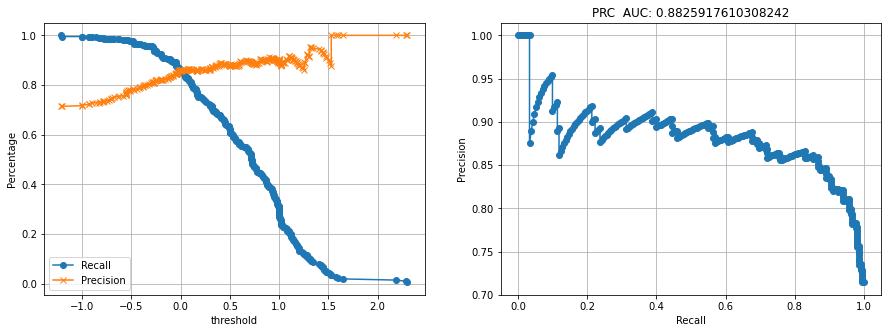

In [158]:
pipe.fit(Xtrain,Ytrain)
plotPRC(Yv,pipe.decision_function(Xv))

In [159]:
print('Validation accuracy:',np.mean(pipe.predict(Xv) == Yv))
print('Training accuracy:',np.mean(pipe.predict(Xtrain) == Ytrain))

Validation accuracy: 0.7966666666666666
Training accuracy: 0.9974074074074074


In [154]:
XtestResults = pipe.decision_function(CompleteXtest)

In [157]:
# pd.DataFrame(np.array(XtestResults)).to_csv("u2191362.csv")